# Inference of COVID-19 vaccines effectiveness and uncertainty using Bayesian methods </center>

Students: **Marco Giunta** (2025169), **Samuele Pio Lipani** (2025168)


#####  <center> Abstract </center>

<center>  </center>


### Packages


In [27]:
library('rjags')
library('tidyverse')
# library('runjags')
library('coda')
library('tidybayes')
library('maps')
library('mapdata')
options(warn = -1)

In [28]:
source('mcmcutilities.R')

### World Data


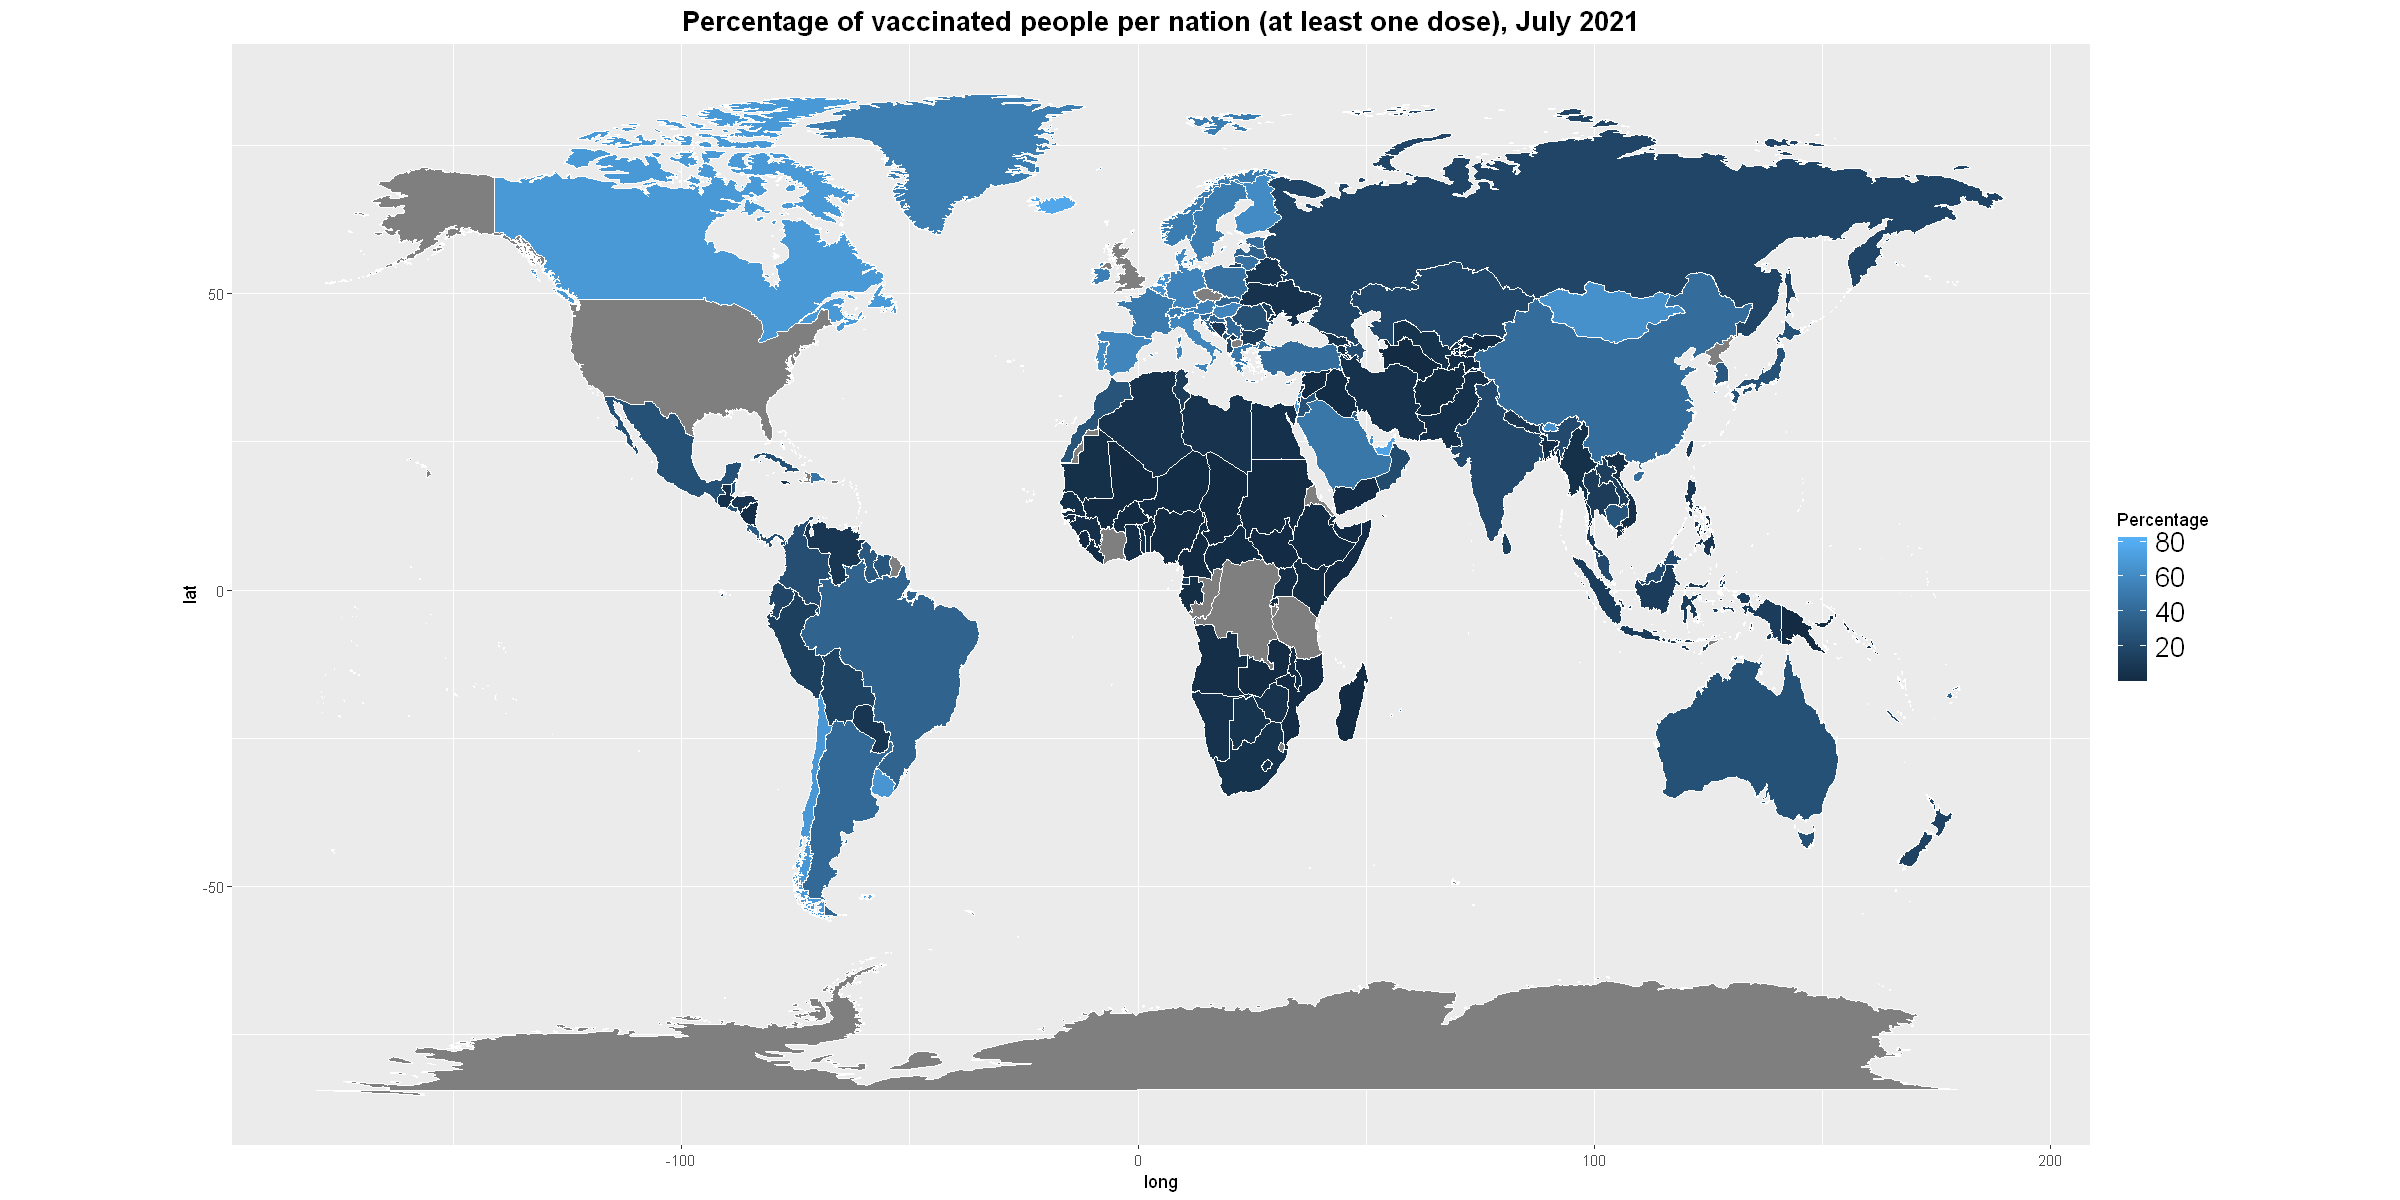

In [30]:
world.map()

## Introduction

Da spiegare il setting del problema ecc ecc 

## Methods 

One of the aim of the project is computing Bayesian inference on different rates of positive detected people depending on their somministration of the vaccine. 
<br> In order to accomplish this task we are going to use Markov chain Monte Carlo methods (Metropolis and Gibbs sampler) to extract samples from the posterior ditributions without actually computing the required integrals. 

**Bayes Theorem**
<br> Statistical inference is the process of using a set of observation data $D$ to infer the parameters $\theta$ of the underlying generative statistical model $M$. Bayesian inference relies on Bayes' Theorem:

$$
P(\theta | D, M) = \frac{P(D | \theta, M)P(\theta | M)}{P(D | M)}
$$

where: 
- P($\theta$ | D, M) is called **posterior** and it represents the reallocation of credibility among parameters when data are fixed;
- P(D | $\theta$, M) is called **likelihood** and it describes the probability distribution of getting the observation dataset, given a certain value of the parameters;
- P($\theta$ | M) is called **prior** and it represents the probability distribution of the parameters, given our background information.
- P(D | M) is the **evidence** and it is a normalization constant (integral).


Our goal in Bayesian inference is to get an accurate representation of the posterior distribution. One way to do that is to sample a large number of representative points from the posterior.
In this particular case inference has to be performed on $\textbf{pv}$ and $\textbf{pp}$ rates values. Eventually the purpose of sampling those points is to compute vaccine effectiveness $\textbf{VE}$. Instead of doing a markov chain that depends on both these two parameters, since they are independent, we decide to perform two separated samplings for each vaccine infection rate. Let's call $\theta$ the parameter of each inference; $\theta$ has values that range on a continuum from zero to one and the relative posterior probability is computed as likelihood times prior. 

We will apply **Metropolis algorithm** as follows:

- it samples from a **target density** by choosing values from a **candidate density**
- the acceptance of the new value (proposal) depends only on the previously accepted value (current value)
- using a symmetric transition probability, we generate a Markov Chain
- the acceptance probability, also called Metropolis ratio, is

$$
\rho = min\left(1, \frac{f(s)}{f(\theta_t)} \frac{Q(\theta_t | s)}{Q(s | \theta_t)} \right)
$$

All the Markov chain simulations have been performed by using `JAGS` (Just Another Gibbs Sampler) and the main libraries `rjags` and `coda` that helped translating JAGS objects into R representable ones.
Notice that we are not exploiting one of the real advantages of Gibbs sampling in high dimensional parameters space because we are computing two separated one dimensional chains for each infection rate parameter. Gibbs algorithm, in this particular case, becomes the Metropolis one with a proposal jump probability that resembles exactly the posterior distribution of that inferred parameter. Therefore each jump is always accepted and the output chain is more efficient and representative of the distribution.

### Markov Chain Monte Carlo algorithm (function)

We have three main goals in generating an MCMC sample from the posterior distribution:

- The values in the chain must be representative of the posterior ditribution. They should not be unduly be influenced by the arbitrary initial value of the chain, and they should fully explore the range of the posterior distribution without getting stuck.
- the chain should be of sufficient size so that that estimates are accurate and stable. In particular the estimates of the central tendency (mode) and 95% HDI should not be much different if the MCMC analysis is run again 
- the chain should be generated efficiently, with a few steps as possibile so not to exceed our patience or computing power.

In [4]:
mchain <- function(data, prior = 'dbeta(1,1)', niter = 15000 , nburnin = 500) { 

# Load the data:
y = data            # The y values are in the column named y.
Ntotal = length(y)  # Compute the total number of "flips".
dataList = list(    # Put the information into a list.
  y = y ,
  Ntotal = Ntotal 
)

# Define the model:
modelString = paste(
"model {
  for ( i in 1:Ntotal ) {
    y[i] ~ dbern( theta )
  }
  theta ~ ",prior,"}")
# close quote for modelString
writeLines( modelString , con="TEMPmodel.txt" )

# Initialize the chains based on MLE of data.
# Option: Use single initial value for all chains:
# thetaInit = sum(y)/length(y)
# initsList = list( theta=thetaInit )
# Option: Use function that generates random values for each chain:
    
initsList = function() {
  resampledY = sample( y , replace=TRUE )
  thetaInit = sum(resampledY)/length(resampledY)
#   thetaInit = 0.001+0.998*thetaInit # keep away from 0,1
  return( list( theta=thetaInit ) )
}

# Run the chains:
jagsModel = jags.model( file="TEMPmodel.txt" , data=dataList , inits=initsList , 
                        n.chains=4 , n.adapt=4000, quiet = TRUE)
update( jagsModel , n.iter=nburnin )
codaSamples = coda.samples( jagsModel , variable.names=c("theta") ,
                            n.iter=niter)
return(codaSamples)
} 

### Markov chain diagnosis

We will put attention on four plots for each Markov chain:

**Top left: trace plot, representativeness**
<br> Generated chains are superimposed. If they are all representative of the posterior distribution they should overlap each other 

**Bottom right: density, representativeness**
<br> It is another visual indicator of the overlap between the output chains. Notice that posterior density estimation is also useful to determine 95% HDI. HDI limits are slightly different for each chain beacuse they are of course finite random samples from the posterior distribution. In the limit, for infinite chains, the HDI extrema will all converge to the same values

**Bottom left: shrink factor**
<br> It measures how much variance there is between chains relative to how much variance there is within chains. If all the chains have settled into a reporesentative sampling, then the average difference between the chains should be the same as the average difference (across steps) within the chains leading to an approximately good value of one.

**Top right: autocorrelation: accuracy**
<br> It is simply the correlation of the chain values with the chain values k steps ahead. It is useful to measure how many effective samples there are eventually inside the chain, each exploring a different part of the parameters space

### Vaccines effectiveness analysis


#### Comirnaty (Pfizer/BioNTech): 

In [5]:
#Comirnaty
rownames = c('tot_old', 'tot_new', '12-15', '16-64', '65-74', 'more75')
vpos = c(8, 77, 0, 7, 1, 0)
ppos = c(162, 850, 18, 143, 14, 5)
vtot = c(18198, 18198, 1131, 14216, 3176, 804)
ptot = c(18325, 18325, 1129, 14299, 3226, 812)
pfizer.df = data.frame(row.names = rownames, vpos=vpos, ppos=ppos, vtot=vtot, ptot=ptot)

pfizer.old <- pfizer.df['tot_old',]
pfizer.data.pv.old <- c(rep(1, len = pfizer.old[[1]]), 
                        rep(0, len = pfizer.old[[3]] - pfizer.old[[1]]))

pfizer.data.pp.old <- c(rep(1, len = pfizer.old[[2]]),
                        rep(0, len = pfizer.old[[4]] - pfizer.old[[2]]))

pfizer.new <- pfizer.df['tot_new',]
pfizer.data.pv.new <- c(rep(1, len = pfizer.new[[1]]), 
                        rep(0, len = pfizer.new[[3]] - pfizer.new[[1]]))

pfizer.data.pp.new <- c(rep(1, len = pfizer.new[[2]]),
                        rep(0, len = pfizer.new[[4]] - pfizer.new[[2]]))

pfizer.data.pv.12 <- c(rep(1, len = pfizer.df['12-15',][[1]]), 
                       rep(0, len = pfizer.df['12-15',][[3]] - pfizer.df['12-15',][[1]]))

pfizer.data.pp.12 <- c(rep(1, len = pfizer.df['12-15',][[2]]), 
                       rep(0, len = pfizer.df['12-15',][[4]] - pfizer.df['12-15',][[2]]))

pfizer.data.pv.16 <- c(rep(1, len = pfizer.df['16-64',][[1]]), 
                       rep(0, len = pfizer.df['16-64',][[3]] - pfizer.df['16-64',][[1]]))

pfizer.data.pp.16 <- c(rep(1, len = pfizer.df['16-64',][[2]]), 
                       rep(0, len = pfizer.df['16-64',][[4]] - pfizer.df['16-64',][[2]]))

pfizer.data.pv.65 <- c(rep(1, len = pfizer.df['65-74',][[1]]), 
                       rep(0, len = pfizer.df['65-74',][[3]] - pfizer.df['65-74',][[1]]))

pfizer.data.pp.65 <- c(rep(1, len = pfizer.df['65-74',][[2]]), 
                       rep(0, len = pfizer.df['65-74',][[4]] - pfizer.df['65-74',][[2]]))

pfizer.data.pv.75 <- c(rep(1, len = pfizer.df['more75',][[1]]), 
                       rep(0, len = pfizer.df['more75',][[3]] - pfizer.df['more75',][[1]]))

pfizer.data.pp.75 <- c(rep(1, len = pfizer.df['more75',][[2]]), 
                       rep(0, len = pfizer.df['more75',][[4]] - pfizer.df['more75',][[2]]))

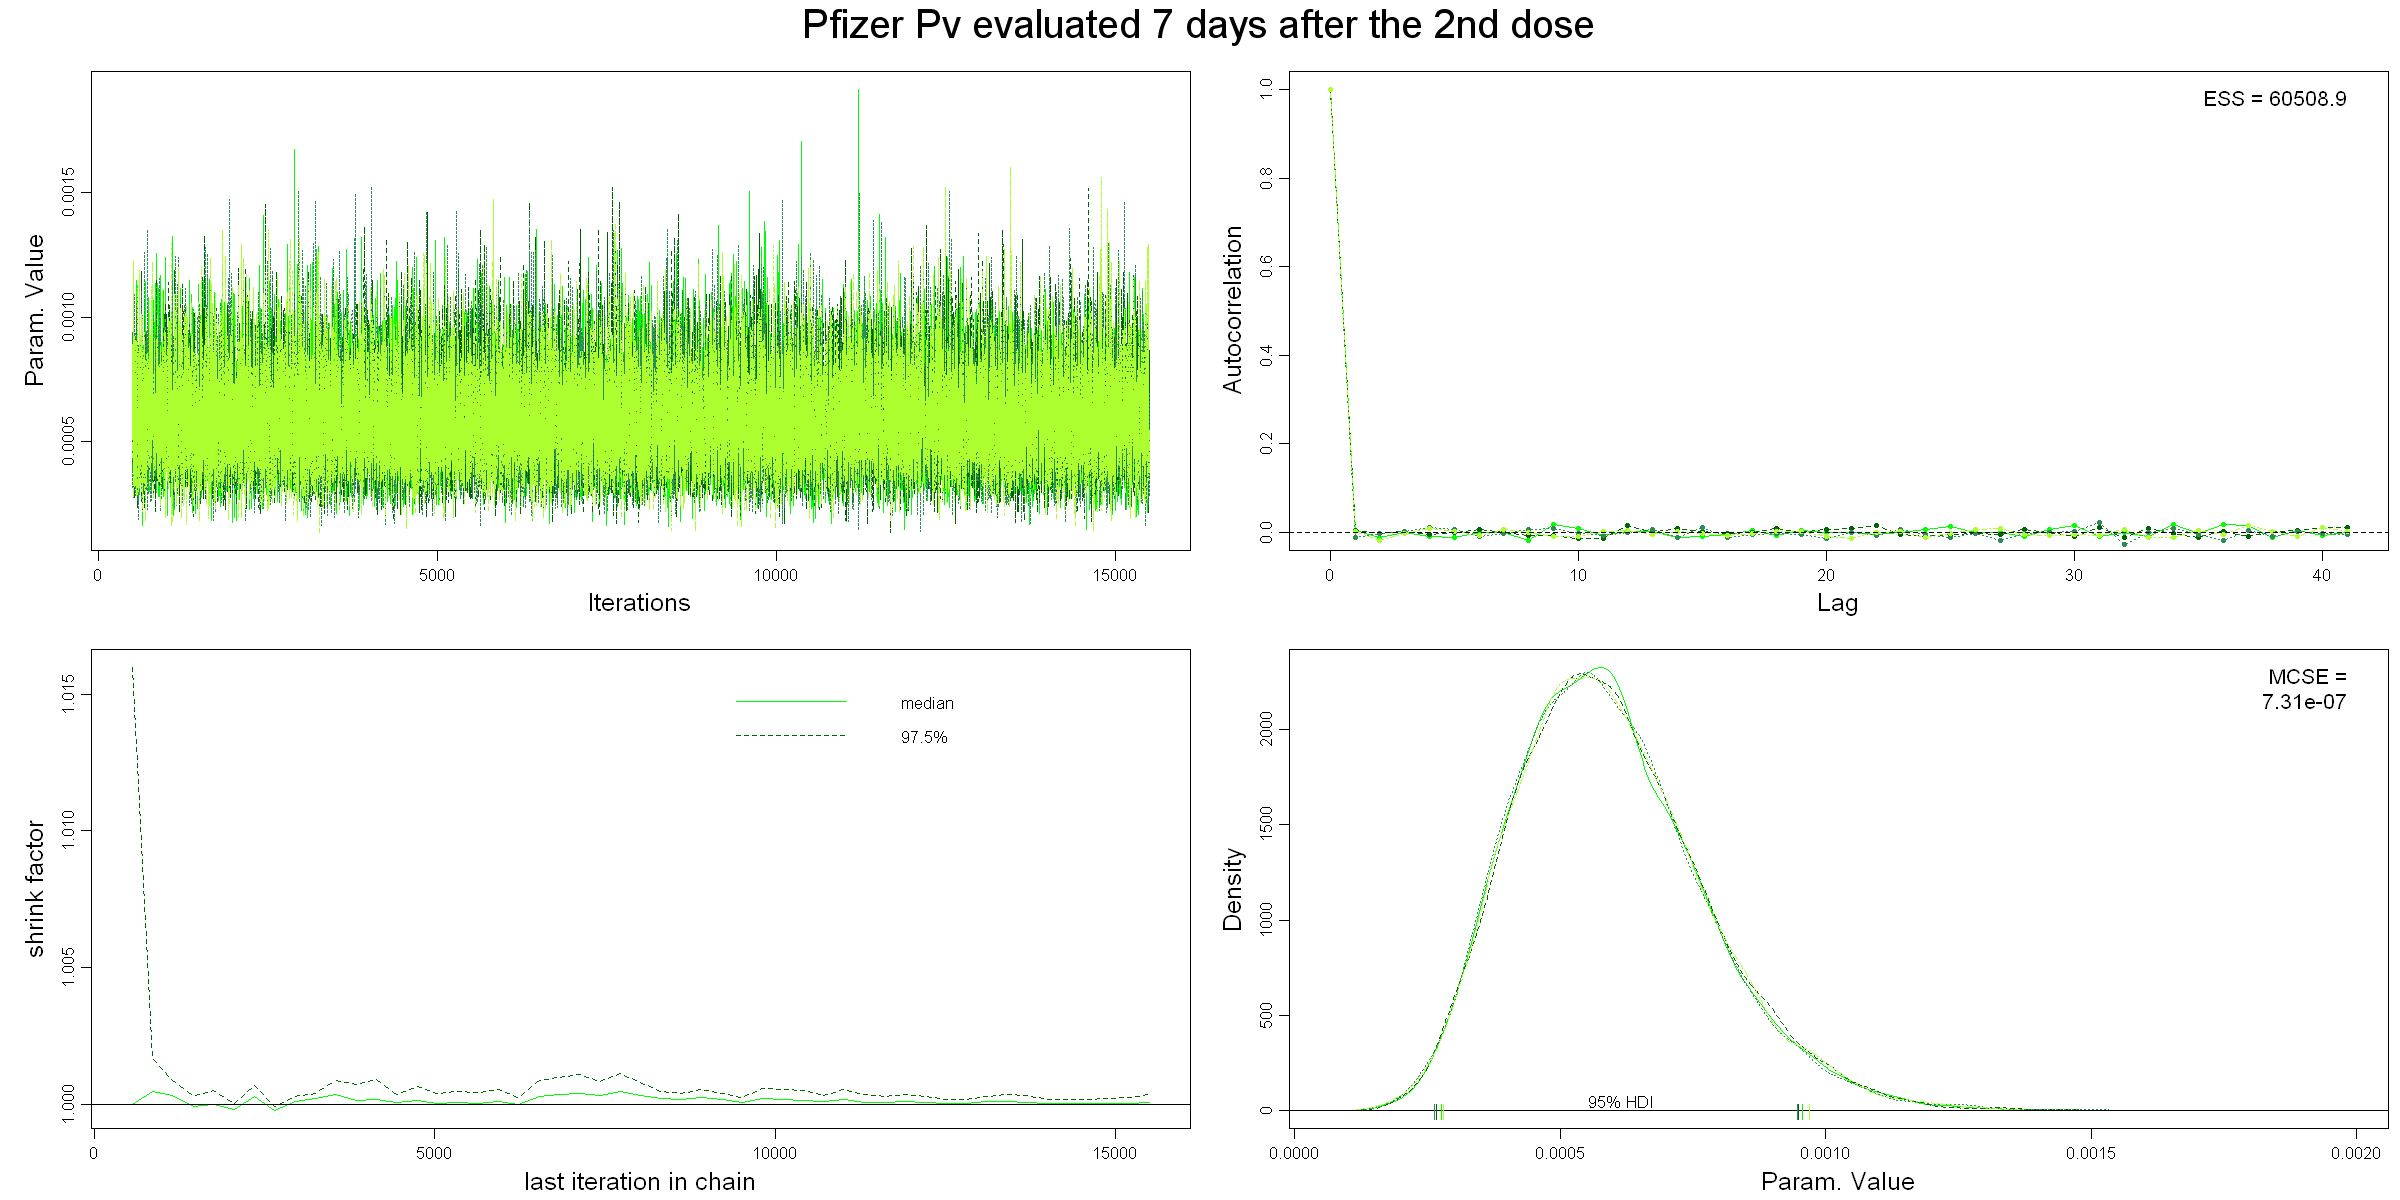

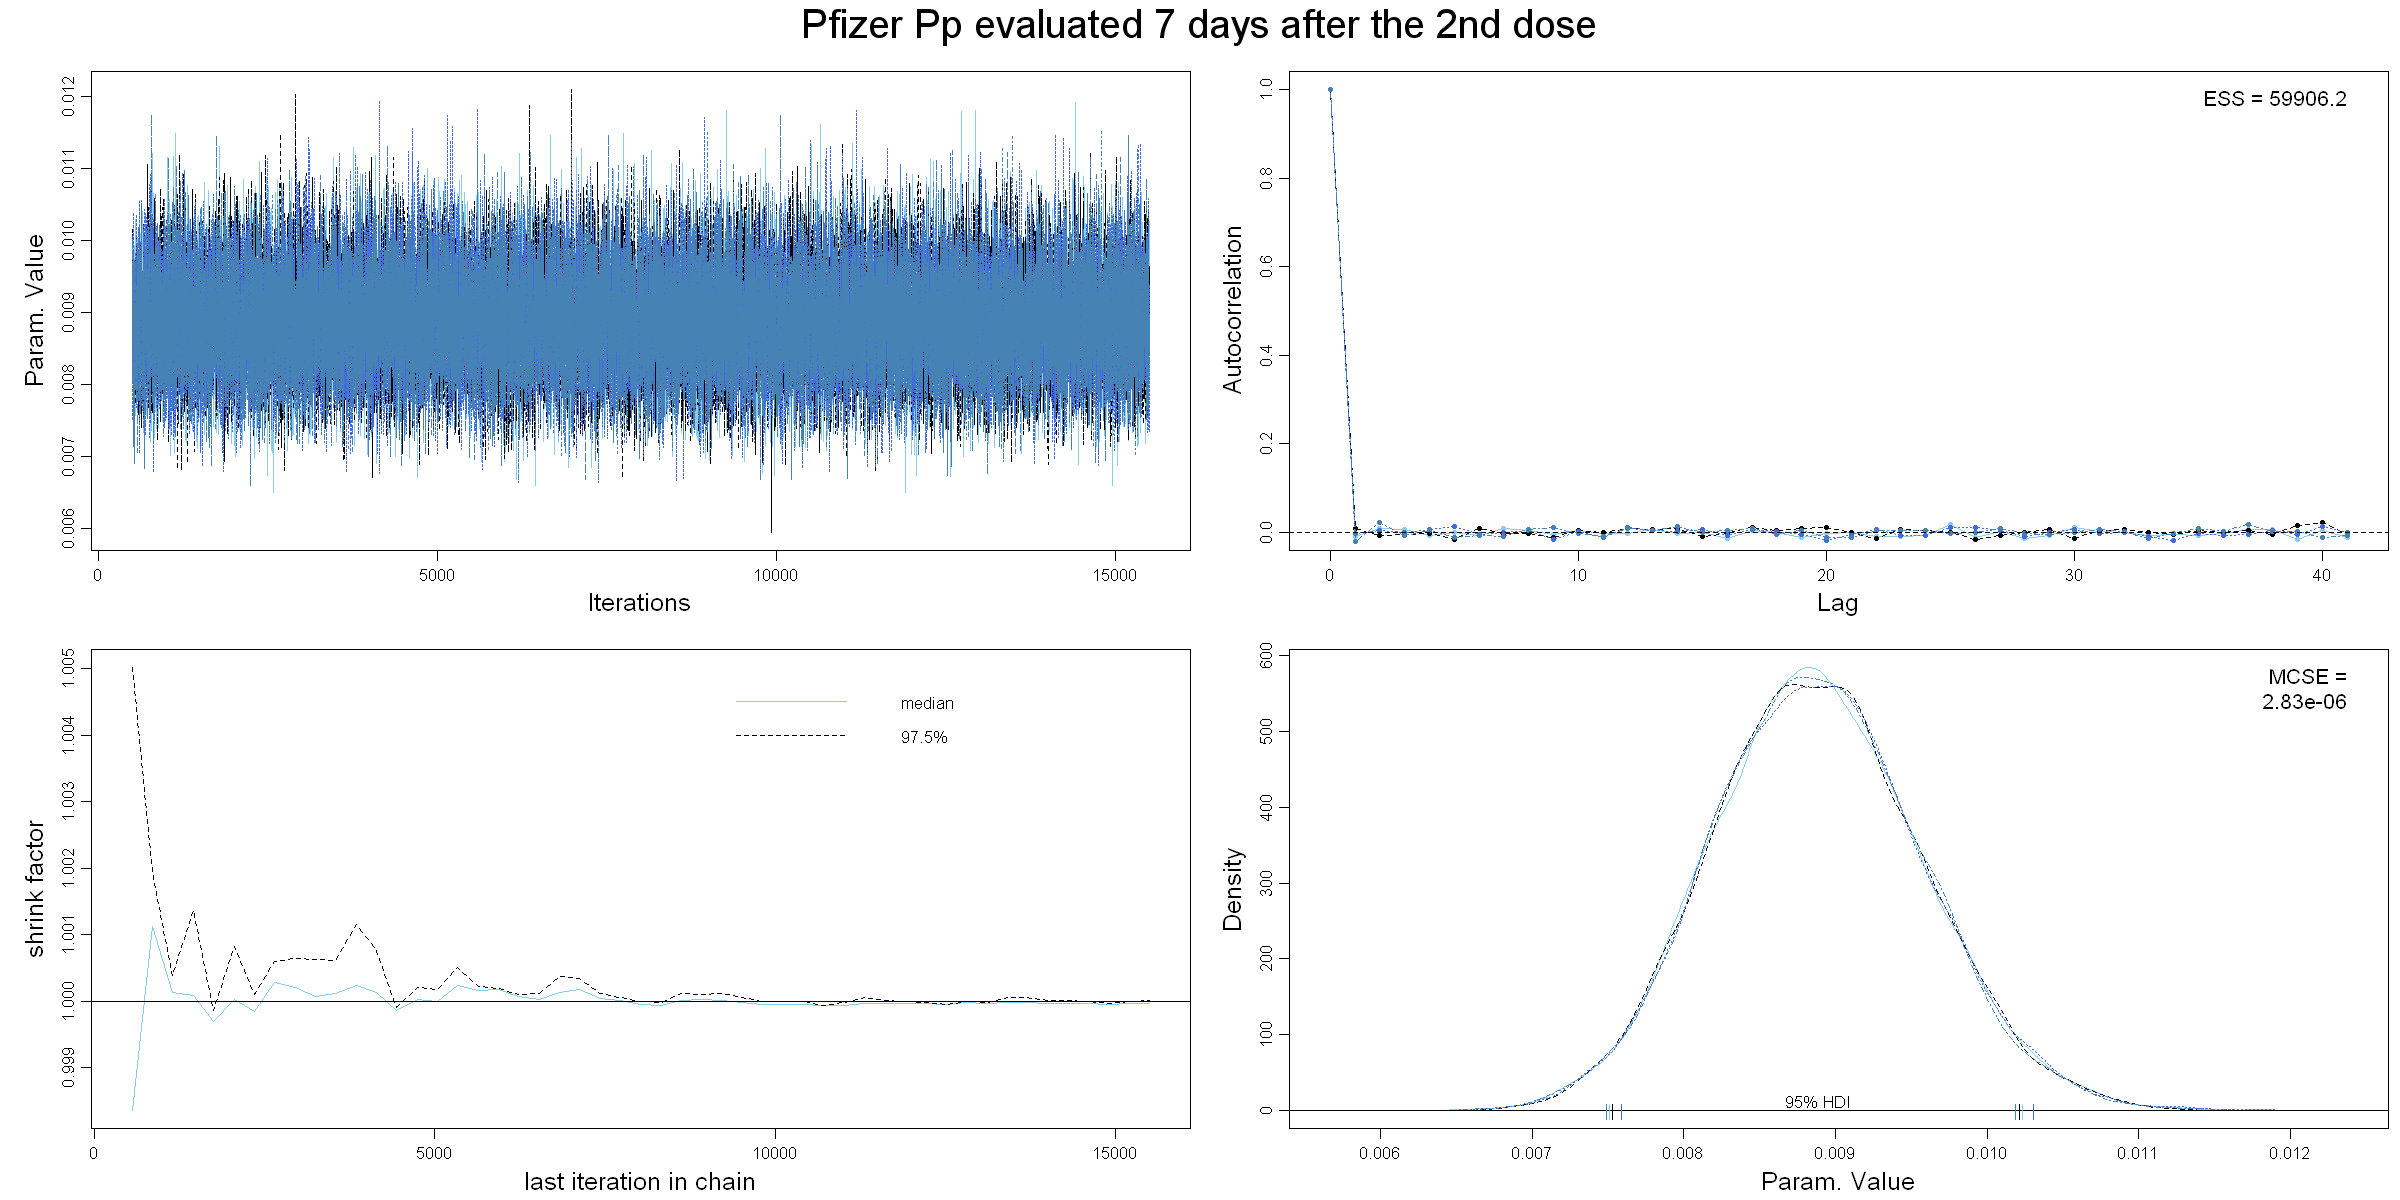

In [6]:
# Examine the chains:
# Convergence diagnostics:

pv.pfizer.old <- mchain(pfizer.data.pv.old, prior = 'dbeta(2.88,93.12)')
pp.pfizer.old <- mchain(pfizer.data.pp.old, prior = 'dbeta(1.41,66.11)')

eff.pfizer.old <- 1 - as.matrix(pv.pfizer.old)/as.matrix(pp.pfizer.old)

diagMCMC( codaObject = pv.pfizer.old , parName="theta", clr = FALSE, title = 'Pfizer Pv evaluated 7 days after the 2nd dose')
diagMCMC( codaObject = pp.pfizer.old , parName="theta", title = 'Pfizer Pp evaluated 7 days after the 2nd dose')

,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
theta,60000,93.2686,93.50561,94.08266,0.95,89.10785,97.07167


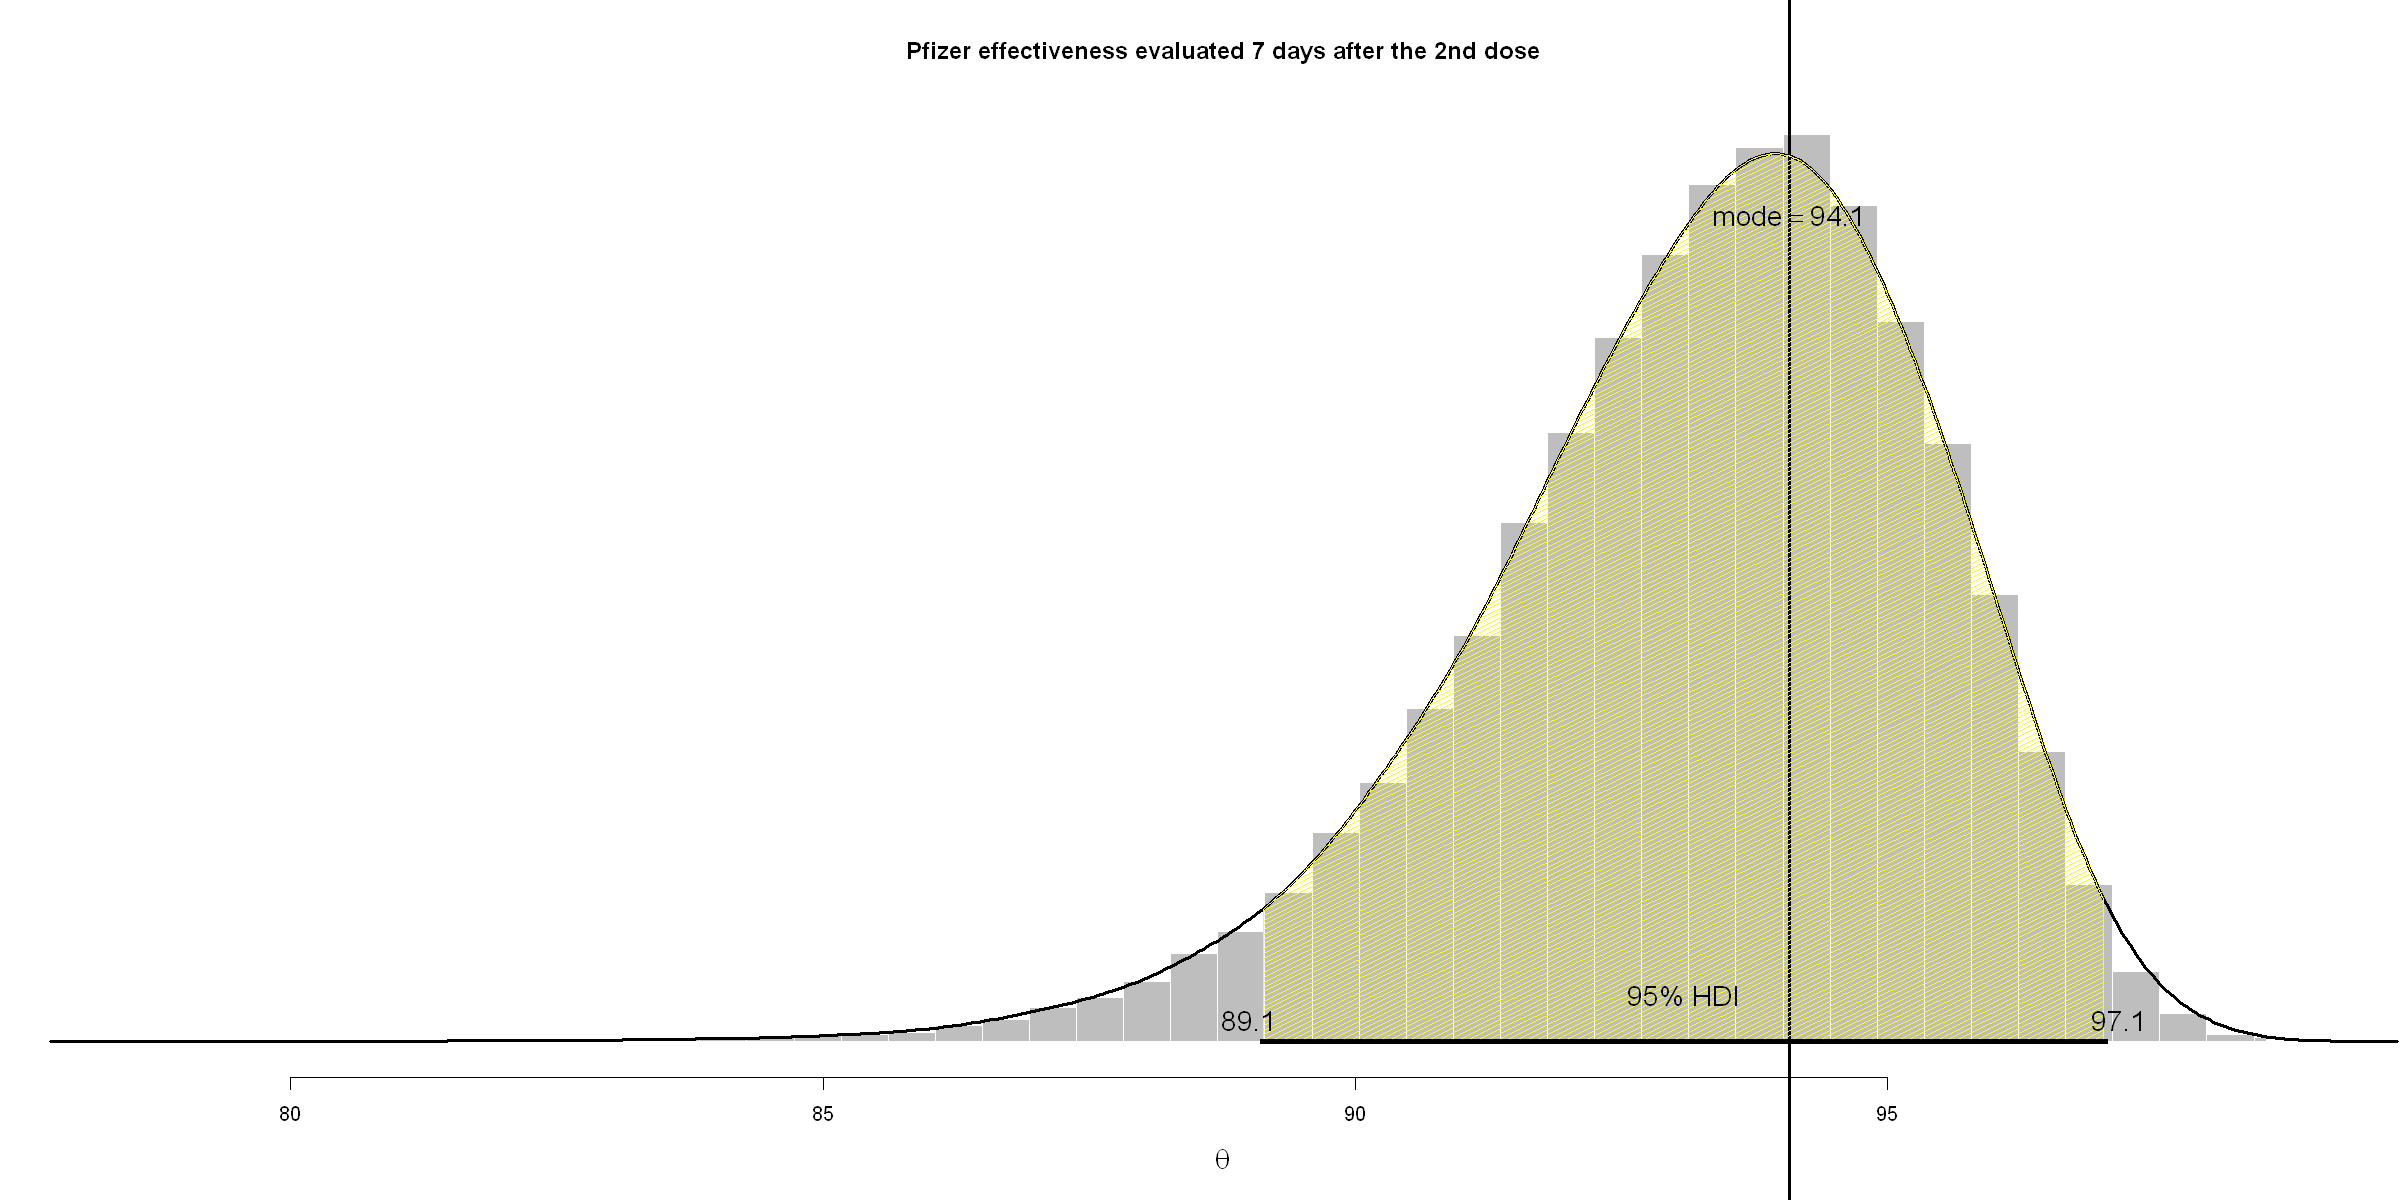

In [7]:
plotPost(eff.pfizer.old*100, main="Pfizer effectiveness evaluated 7 days after the 2nd dose", xlab=bquote(theta), showCurve=TRUE, 
         hdicol = 'Yellow')

In [8]:
pv.pfizer.new <- mchain(pfizer.data.pv.new, prior = 'dbeta(2.88,93.12)')
pp.pfizer.new <- mchain(pfizer.data.pp.new, prior = 'dbeta(1.41,66.11)')
eff.pfizer.new <- 1 - as.matrix(pv.pfizer.new)/as.matrix(pp.pfizer.new)

,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
theta,60000,90.55444,90.59917,90.66253,0.95,88.35817,92.65609


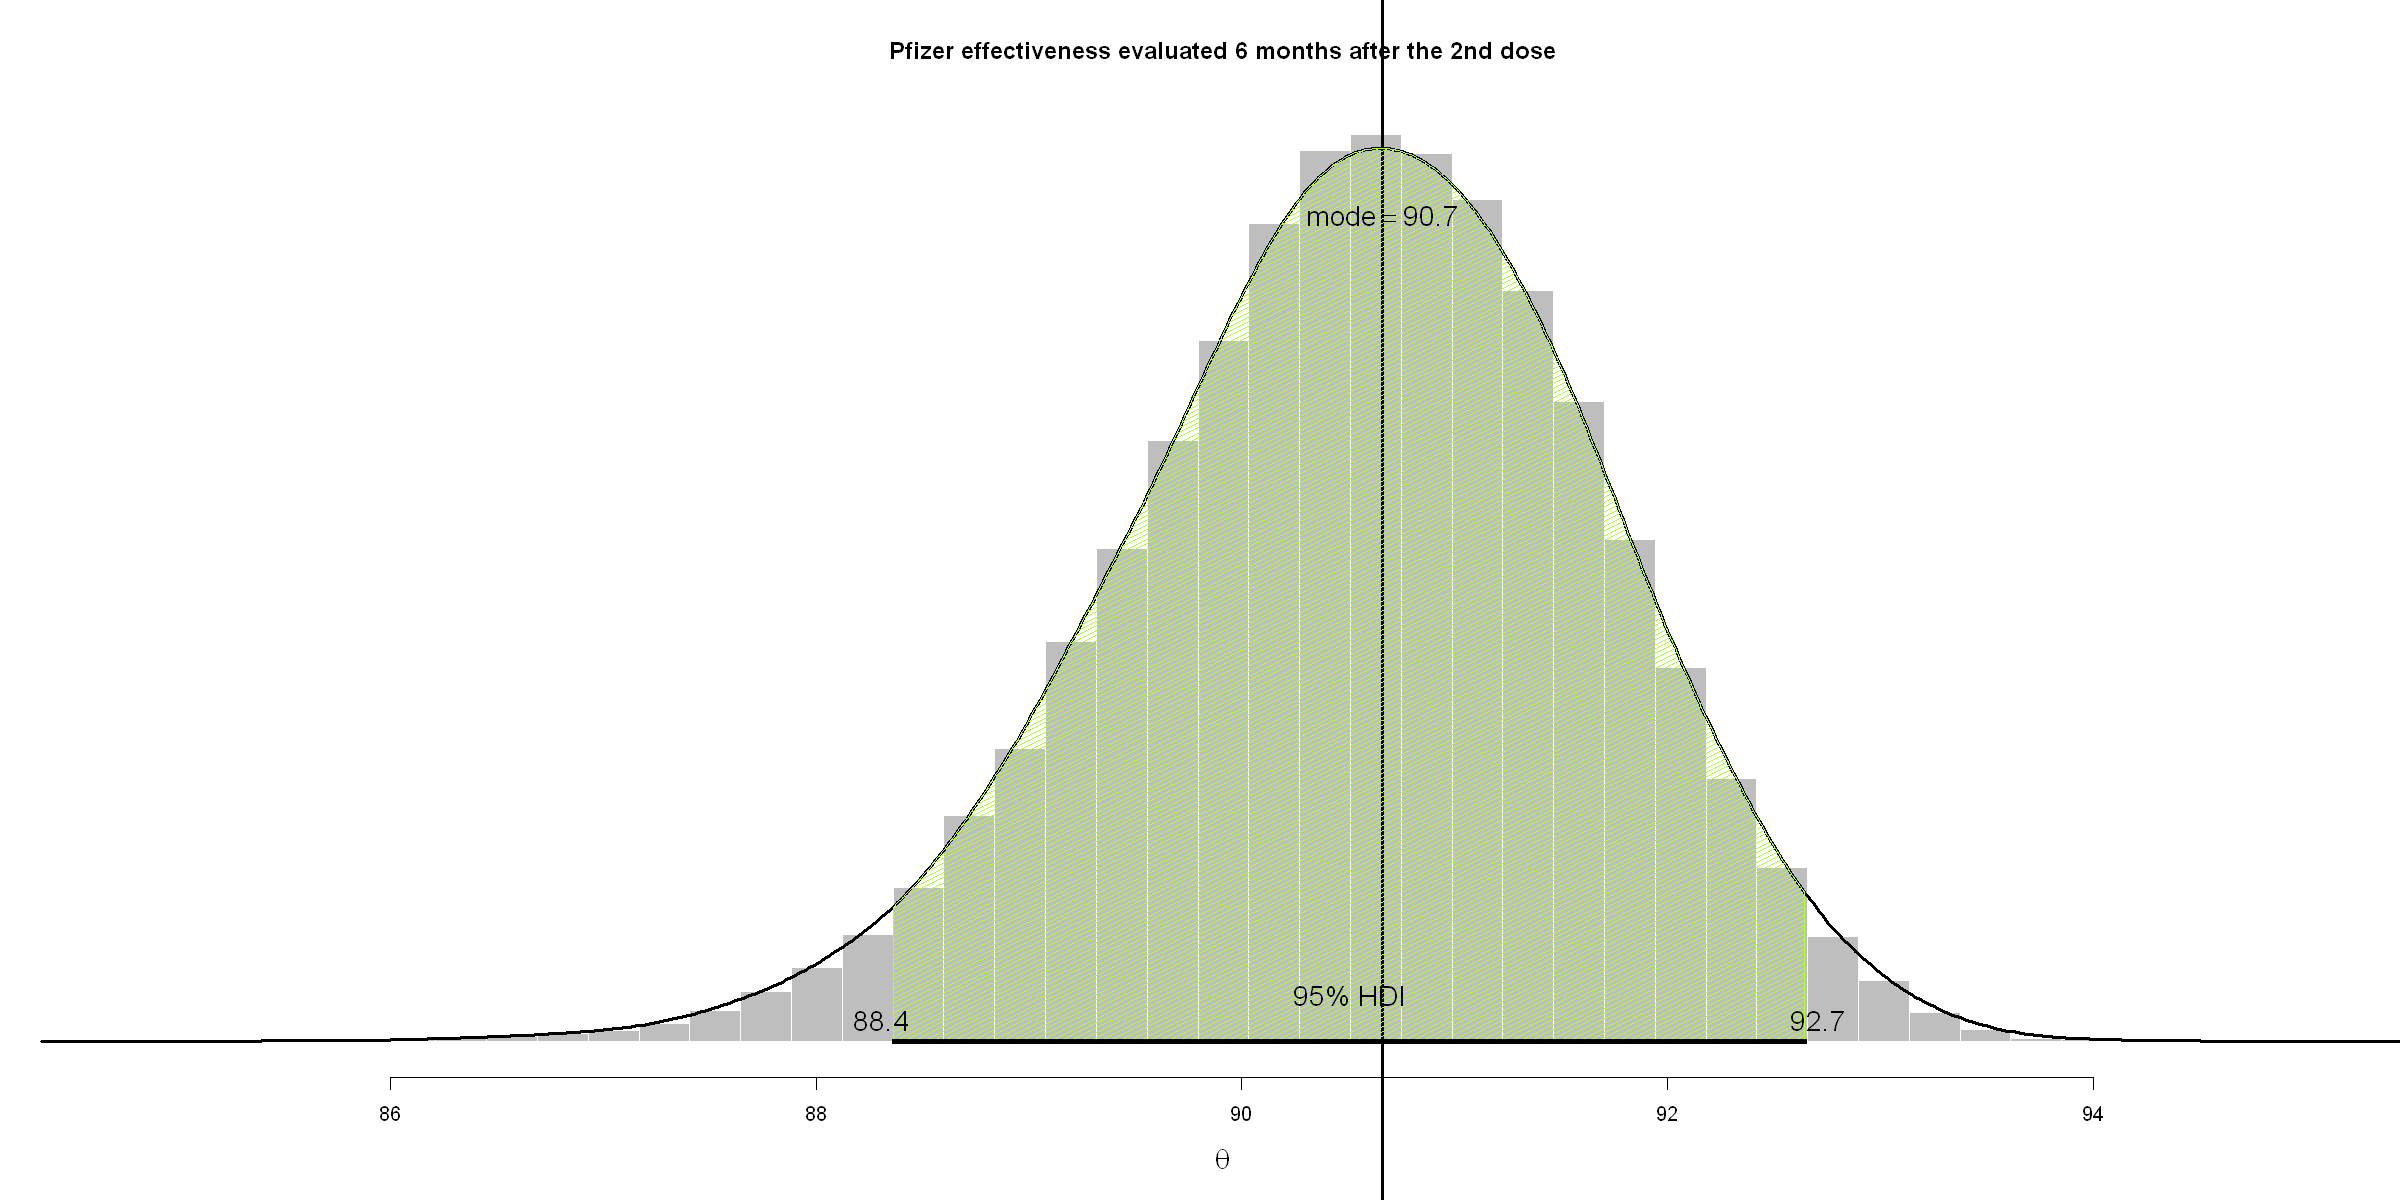

In [9]:
plotPost(eff.pfizer.new*100, main="Pfizer effectiveness evaluated 6 months after the 2nd dose", xlab=bquote(theta), showCurve=TRUE, 
         hdicol = 'greenyellow')

#### Moderna:

,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
theta,58550.27,92.55136,92.74321,93.07752,0.95,88.32892,96.23888


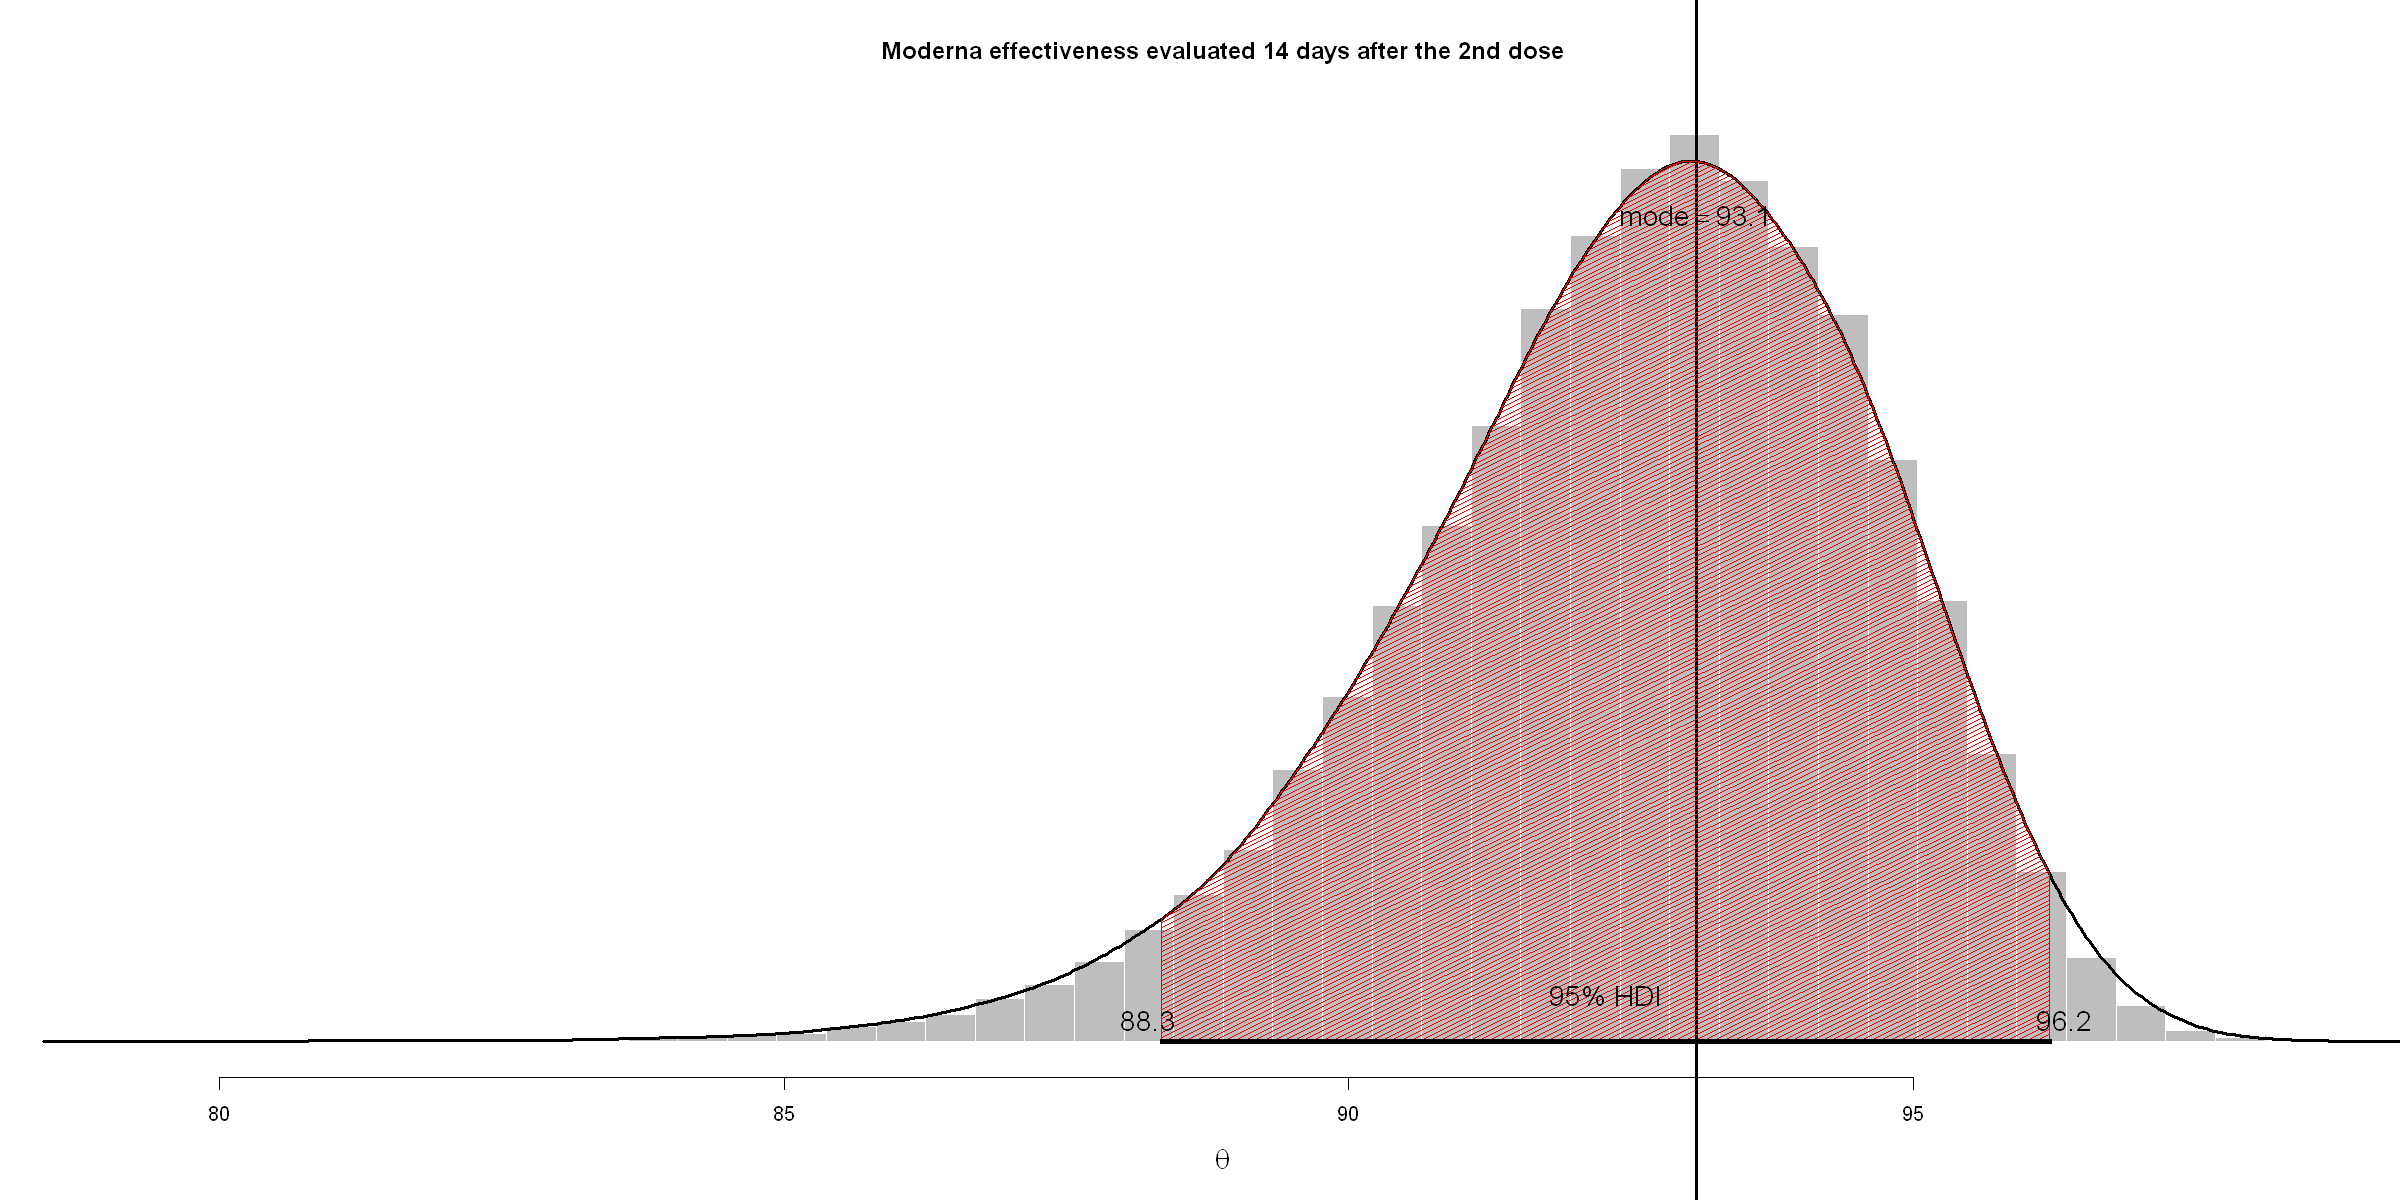

In [10]:
#Moderna
young.pop= 3732
vratio = 2/3
moderna.df <- data.frame(
              row.names=c('tot', '12-17', '18-64', 'more65'),
              vpos=c(11, 0, 7, 4),
              ppos=c(185, 4, 156, 29),
              vtot=c(14134, young.pop*vratio, 10551, 3583),
              ptot=c(14073, young.pop*(1-vratio), 10521, 3552))

moderna <- moderna.df['tot',]
moderna.data.pv <- c(rep(1, len = moderna[[1]]), 
                        rep(0, len = moderna[[3]] - moderna[[1]]))

moderna.data.pp <- c(rep(1, len = moderna[[2]]),
                        rep(0, len = moderna[[4]] - moderna[[2]]))

moderna.data.pv.12 <- c(rep(1, len = moderna.df['12-17',][[1]]),
                        rep(0, len = moderna.df['12-17',][[3]] - moderna.df['12-17',][[1]]))

moderna.data.pp.12 <- c(rep(1, len = moderna.df['12-17',][[2]]),
                        rep(0, len = moderna.df['12-17',][[4]] - moderna.df['12-17',][[2]]))

moderna.data.pv.18 <- c(rep(1, len = moderna.df['18-64',][[1]]),
                        rep(0, len = moderna.df['18-64',][[3]] - moderna.df['18-64',][[1]]))

moderna.data.pp.18 <- c(rep(1, len = moderna.df['18-64',][[2]]),
                        rep(0, len = moderna.df['18-64',][[4]] - moderna.df['18-64',][[2]]))

moderna.data.pv.65 <- c(rep(1, len = moderna.df['more65',][[1]]),
                        rep(0, len = moderna.df['more65',][[3]] - moderna.df['more65',][[1]]))

moderna.data.pp.65 <- c(rep(1, len = moderna.df['more65',][[2]]),
                        rep(0, len = moderna.df['more65',][[4]] - moderna.df['more65',][[2]]))

pv.moderna <- mchain(moderna.data.pv, prior = 'dbeta(2.88,93.12)')
pp.moderna <- mchain(moderna.data.pp, prior = 'dbeta(1.41,66.11)')

eff.moderna <- 1 - as.matrix(pv.moderna)/as.matrix(pp.moderna)

plotPost(eff.moderna*100, main="Moderna effectiveness evaluated 14 days after the 2nd dose", xlab=bquote(theta), showCurve=TRUE,
         hdicol = 'red')

#### Vaxzevria:

,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
theta,60000,65.21587,65.44421,66.18874,0.95,56.80191,73.66447


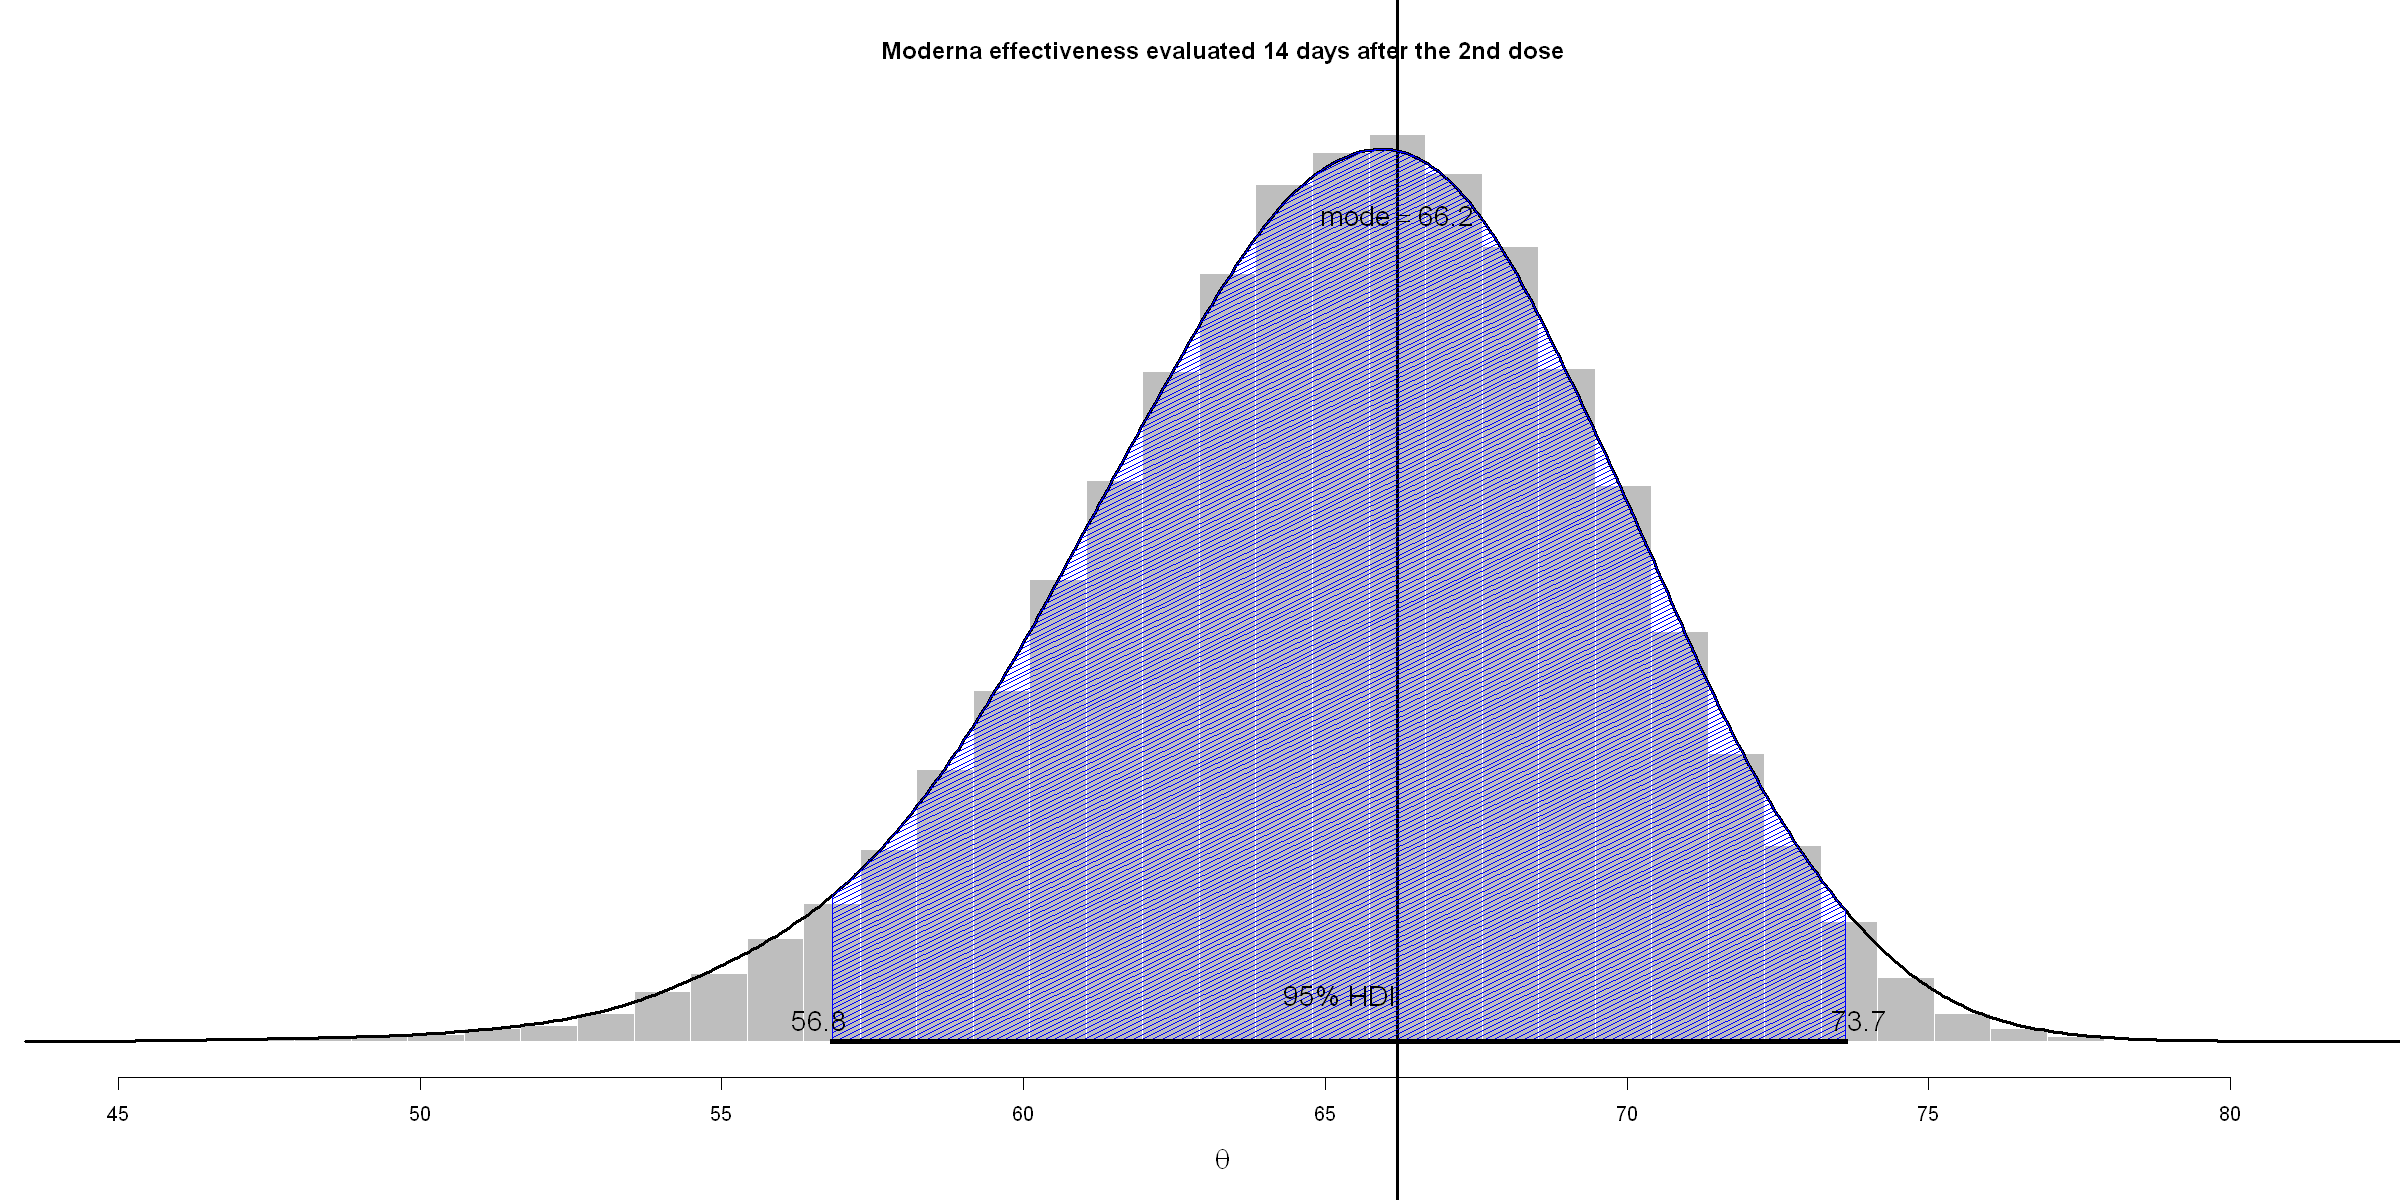

In [11]:
#Vaxzevria
rownames = c('tot')
vpos = c(84)
ppos = c(248)
vtot = c(8597)
ptot = c(8581)
vaxz.df =  data.frame(row.names = rownames, vpos=vpos, ppos=ppos, vtot=vtot, ptot=ptot)

vaxz <- vaxz.df['tot',]
vaxz.data.pv <- c(rep(1, len = vaxz[[1]]), 
                        rep(0, len = vaxz[[3]] - vaxz[[1]]))

vaxz.data.pp <- c(rep(1, len = vaxz[[2]]),
                        rep(0, len = vaxz[[4]] - vaxz[[2]]))

pv.vaxz <- mchain(vaxz.data.pv, prior = 'dbeta(2.88,93.12)')
pp.vaxz <- mchain(vaxz.data.pp, prior = 'dbeta(1.41,66.11)')

eff.vaxz <- 1 - as.matrix(pv.vaxz)/as.matrix(pp.vaxz)

plotPost(eff.vaxz*100, main="Moderna effectiveness evaluated 14 days after the 2nd dose", xlab=bquote(theta), showCurve=TRUE, hdicol = 'blue')

#### Janssen

,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
theta,60000,65.83148,65.99748,66.25647,0.95,58.67146,72.73962


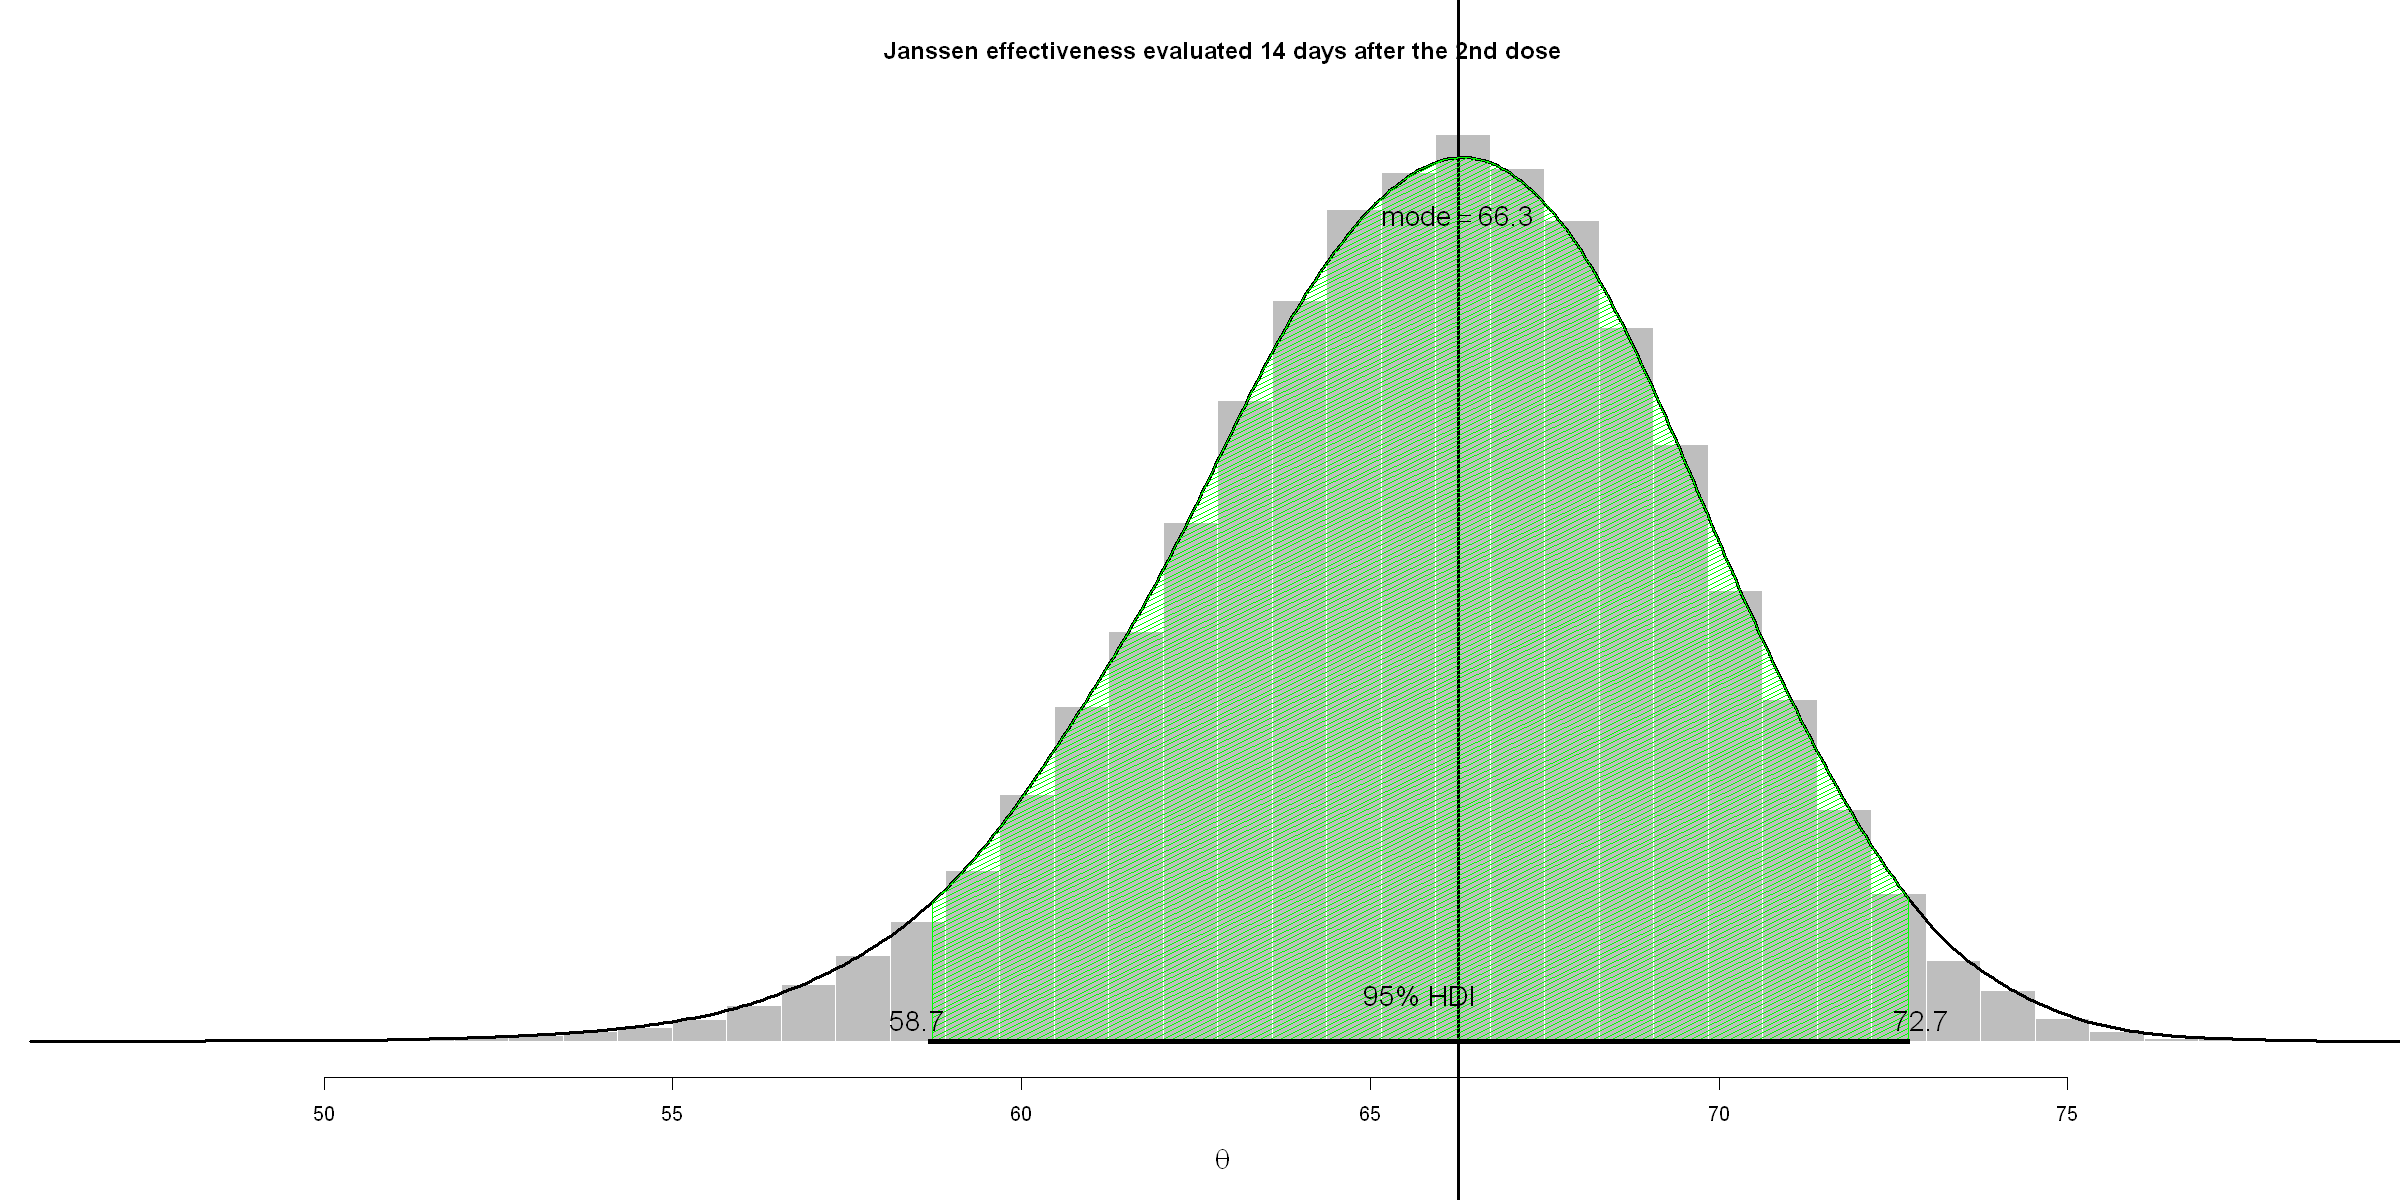

In [12]:
#Janssen
janssen.df <- data.frame(
              row.names=c('tot', '18-59', 'more60'),
              vpos=c(116, 95, 21),
              ppos=c(348, 260, 88),
              vtot=c(19630, 12830, 6800),
              ptot=c(19691, 12881, 6810))

janssen <- janssen.df['tot',]
janssen.data.pv <- c(rep(1, len = janssen[[1]]), 
                        rep(0, len = janssen[[3]] - janssen[[1]]))

janssen.data.pp <- c(rep(1, len = janssen[[2]]),
                        rep(0, len = janssen[[4]] - janssen[[2]]))

janssen.data.pv.18 <- c(rep(1, len = janssen.df['18-59',][[1]]),
                        rep(0, len = janssen.df['18-59',][[3]] - janssen.df['18-59',][[1]]))

janssen.data.pp.18 <- c(rep(1, len = janssen.df['18-59',][[2]]),
                        rep(0, len = janssen.df['18-59',][[4]] - janssen.df['18-59',][[2]]))

janssen.data.pv.60 <- c(rep(1, len = janssen.df['more60',][[1]]),
                        rep(0, len = janssen.df['more60',][[3]] - janssen.df['more60',][[1]]))

janssen.data.pp.60 <- c(rep(1, len = janssen.df['more60',][[2]]),
                        rep(0, len = janssen.df['more60',][[4]] - janssen.df['more60',][[2]]))


pv.janssen <- mchain(janssen.data.pv, prior = 'dbeta(2.88,93.12)')
pp.janssen <- mchain(janssen.data.pp, prior = 'dbeta(1.41,66.11)')

eff.janssen <- 1 - as.matrix(pv.janssen)/as.matrix(pp.janssen)

plotPost(eff.janssen*100, main="Janssen effectiveness evaluated 14 days after the 2nd dose", xlab=bquote(theta), showCurve=TRUE, 
         hdicol = 'green')

### Comparison between vaccine effectiveness

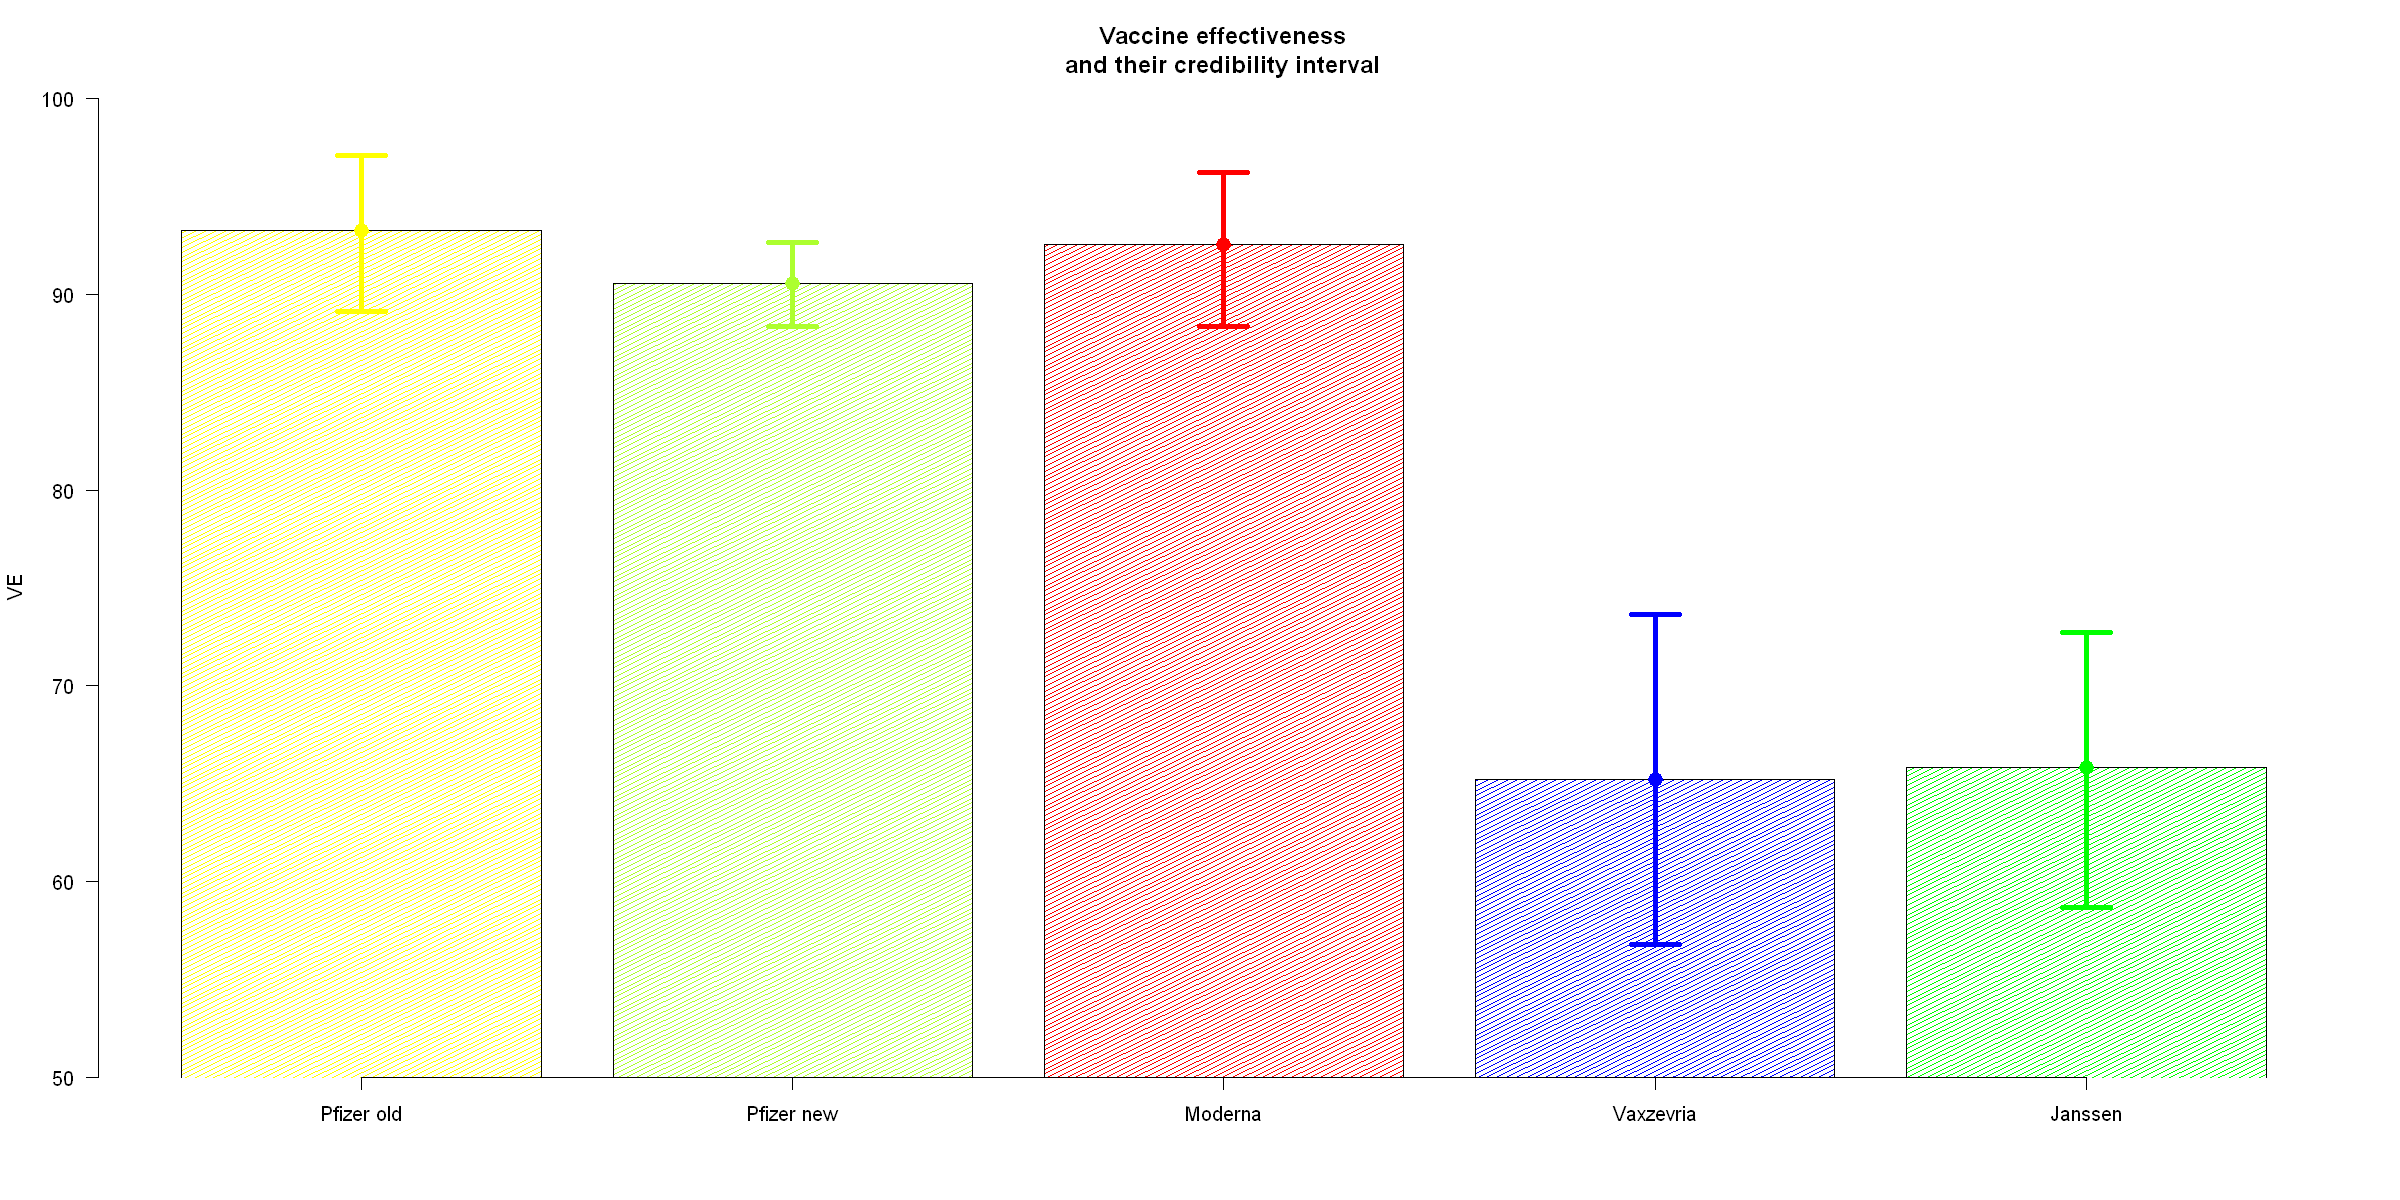

In [13]:
vacc.list <- list(eff.pfizer.old, eff.pfizer.new, eff.moderna, eff.vaxz, eff.janssen)
barcomparator(vacc.list)

### Age dependent effectiveness comparison 


In [14]:
# comparison is between Pfizer, Moderna and Janssen that actually present different age ranges vaccine effectiveness data

pfizer.pv <- list()
pfizer.pp <- list()
pfizer.pv[[1]] <- as.matrix(mchain(pfizer.data.pv.12, prior = 'dbeta(2.88,93.12)'))
pfizer.pp[[1]] <- as.matrix(mchain(pfizer.data.pp.12, prior = 'dbeta(1.41,66.11)'))
pfizer.pv[[2]] <- as.matrix(mchain(pfizer.data.pv.16, prior = 'dbeta(2.88,93.12)'))
pfizer.pp[[2]] <- as.matrix(mchain(pfizer.data.pp.16, prior = 'dbeta(1.41,66.11)'))
pfizer.pv[[3]] <- as.matrix(mchain(pfizer.data.pv.65, prior = 'dbeta(2.88,93.12)'))
pfizer.pp[[3]] <- as.matrix(mchain(pfizer.data.pp.65, prior = 'dbeta(1.41,66.11)'))
pfizer.pv[[4]] <- as.matrix(mchain(pfizer.data.pv.75, prior = 'dbeta(2.88,93.12)'))
pfizer.pp[[4]] <- as.matrix(mchain(pfizer.data.pp.75, prior = 'dbeta(1.41,66.11)'))

moderna.pv <- list()
moderna.pp <- list()
moderna.pv[[1]] <- as.matrix(mchain(moderna.data.pv.12, prior = 'dbeta(2.88,93.12)'))
moderna.pp[[1]] <- as.matrix(mchain(moderna.data.pp.12, prior = 'dbeta(1.41,66.11)'))
moderna.pv[[2]] <- as.matrix(mchain(moderna.data.pv.18, prior = 'dbeta(2.88,93.12)'))
moderna.pp[[2]] <- as.matrix(mchain(moderna.data.pp.18, prior = 'dbeta(1.41,66.11)'))
moderna.pv[[3]] <- as.matrix(mchain(moderna.data.pv.65, prior = 'dbeta(2.88,93.12)'))
moderna.pp[[3]] <- as.matrix(mchain(moderna.data.pp.65, prior = 'dbeta(1.41,66.11)'))

janssen.pv <- list()
janssen.pp <- list()
janssen.pv[[1]] <- as.matrix(mchain(janssen.data.pv.18, prior = 'dbeta(2.88,93.12)'))
janssen.pp[[1]] <- as.matrix(mchain(janssen.data.pp.18, prior = 'dbeta(1.41,66.11)'))
janssen.pv[[2]] <- as.matrix(mchain(janssen.data.pv.60, prior = 'dbeta(2.88,93.12)'))
janssen.pp[[2]] <- as.matrix(mchain(janssen.data.pp.60, prior = 'dbeta(1.41,66.11)'))

In [15]:
ageinference(moderna.df, moderna.pv, moderna.pp)
ageinference(pfizer.df, pfizer.pv, pfizer.pp)
ageinference(janssen.df, janssen.pv, janssen.pp)

,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
12-17,60961.17,66.82472,74.3091,84.58224,0.95,14.96224,98.91529
18-64,60000.00,93.71776,93.9572,94.40657,0.95,89.63886,97.48602
more65,58882.09,76.99066,78.5800,81.32098,0.95,57.35989,93.48829


,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
12-15,58704.94,84.75152,86.87356,91.27079,0.95,65.43877,98.89529
16-64,60000.00,93.08905,93.35157,93.74960,0.95,88.60095,97.18362
65-74,59592.34,72.92998,76.36200,82.05962,0.95,41.41366,96.54837
more75,60000.00,47.63943,58.73428,76.42210,0.95,-31.21671,98.12047


,ESS,mean,median,mode,hdiMass,hdiLow,hdiHigh
18-59,62140.44,62.33112,62.55505,63.60244,0.95,53.49669,70.75760
more60,60000.00,73.05530,73.62074,75.59793,0.95,60.55267,84.41693


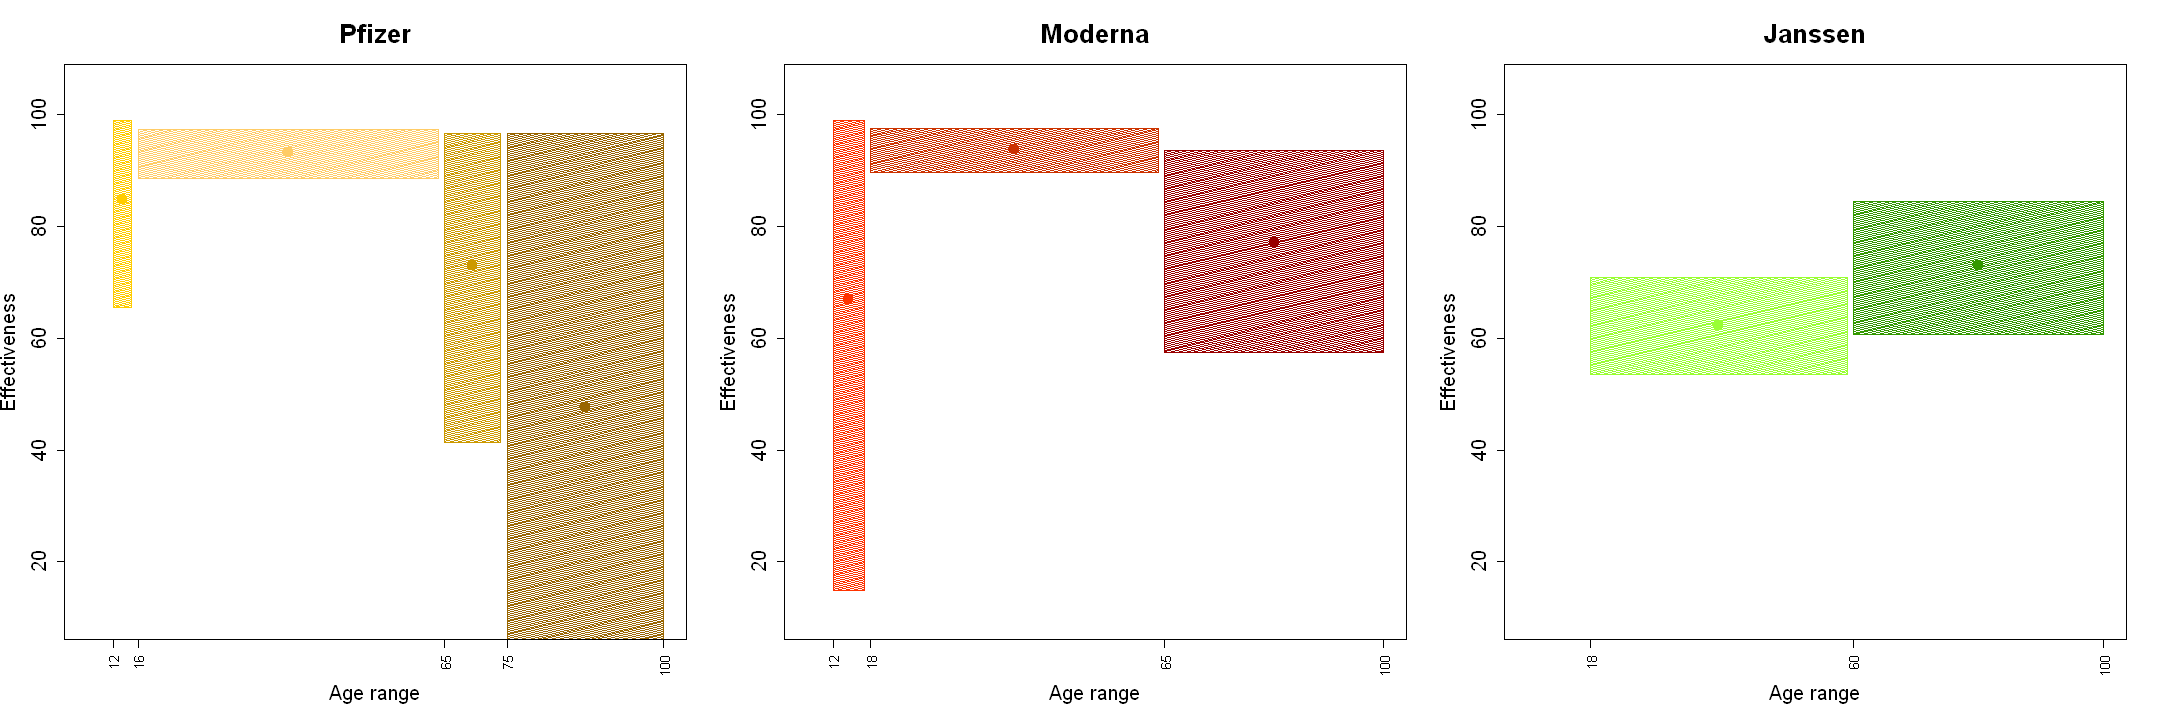

In [16]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(1,3))
pfizer.age.fun()
moderna.age.fun()
janssen.age.fun()

### Conjugate Prior (Pfizer)



In [25]:
# faccio un posterior uguale a 1 - pv/pp dove pv e pp sono due beta distributions che escono fuori dai loro due rispettivi conjugate priors
# impossibile fare il rapporto delle due pdf e ottenere la pdf dell'effectiveness, devo lavorare con samples estratti dalle beta distr (rapporto tra due beta non è più una beta)

posterior <- function(yv=sum(pfizer.data.pv.old),nv=length(pfizer.data.pv.old), yp=sum(pfizer.data.pp.old), np=length(pfizer.data.pp.old)) {
    set.seed(1234)
    pv <- rbeta(10**5, shape1 = 2.88 + yv, shape2 = 93.12 + nv - yv)
    set.seed(1234)
    pp <- rbeta(10**5, shape1 = 1.41 + yp, shape2 = 66.11 + np - yp)
    eff <- ((pp - pv)/pp)*100
    den <- density(eff)
    return(den)
}

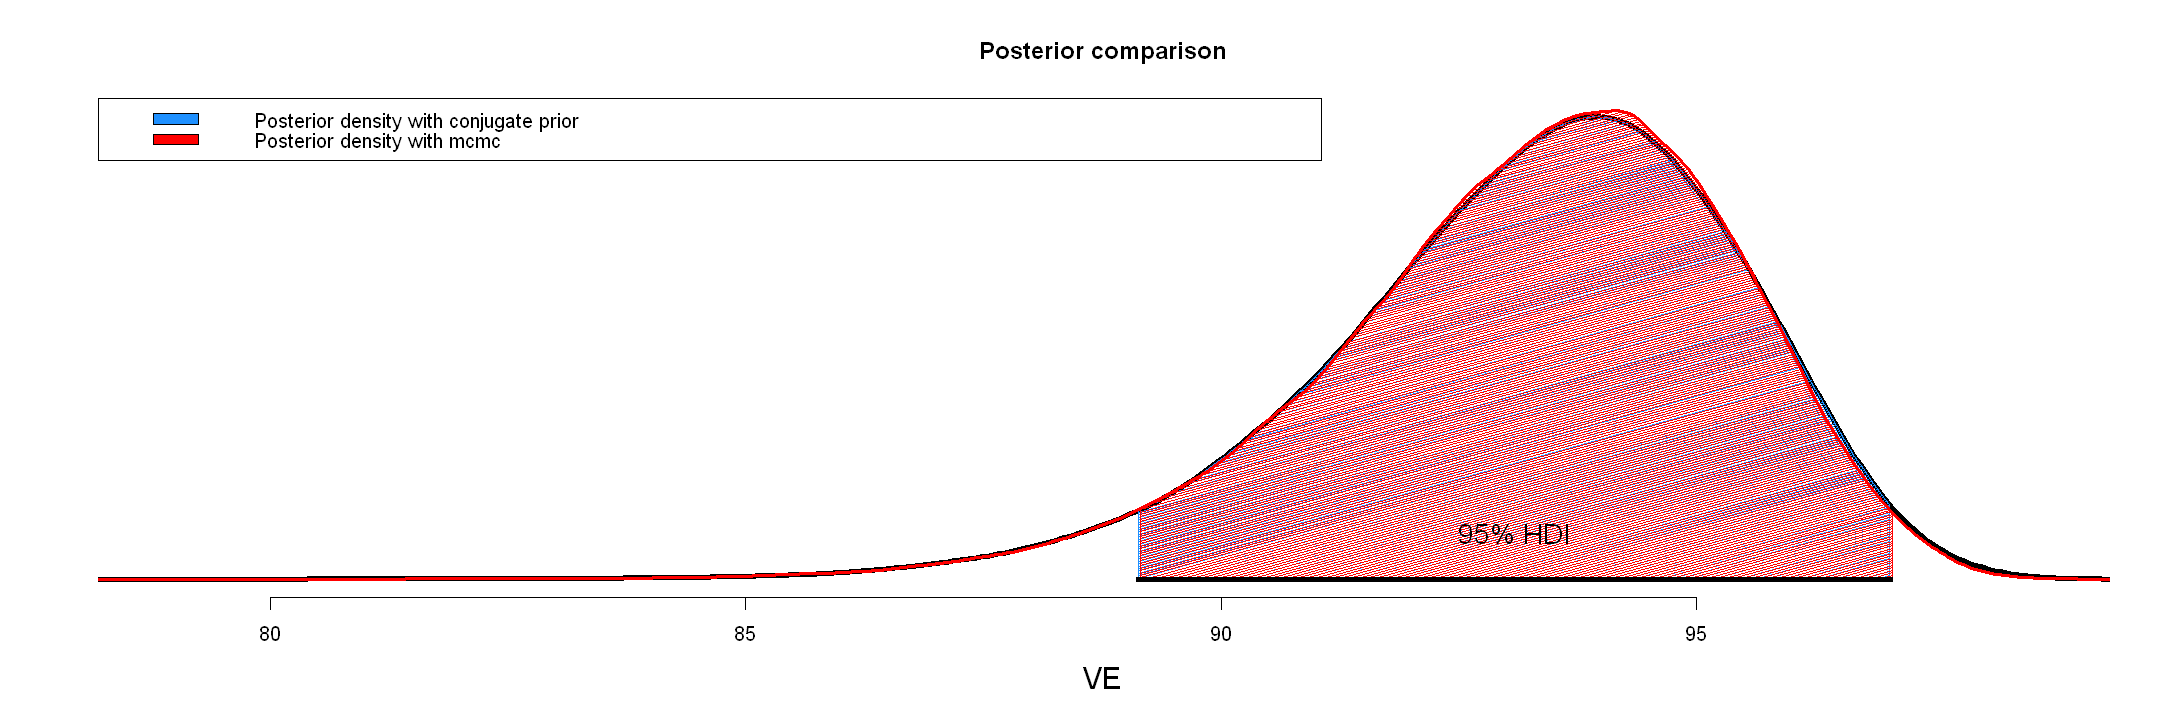

In [26]:
plotPost1(eff.pfizer.old*100, posterior(), main="Posterior comparison", xlab="VE", showCurve=TRUE, 
         hdicol1 = 'dodgerblue', hdicol2 = "red")

### Uniform prior vs beta prior (Pfizer)


In [19]:
posterior.uniform <- function(yv=sum(pfizer.data.pv.old),nv=length(pfizer.data.pv.old), yp=sum(pfizer.data.pp.old), 
                              np=length(pfizer.data.pp.old)) {
    set.seed(1234)
    pv <- rbinom(10**5,size = nv, prob = yv/nv)
    set.seed(1234)
    pp <- rbinom(10**5,size = np, prob = yp/np)
    eff <- ((pp - pv)/pp)*100
    den <- density(eff)
    return(den)
}

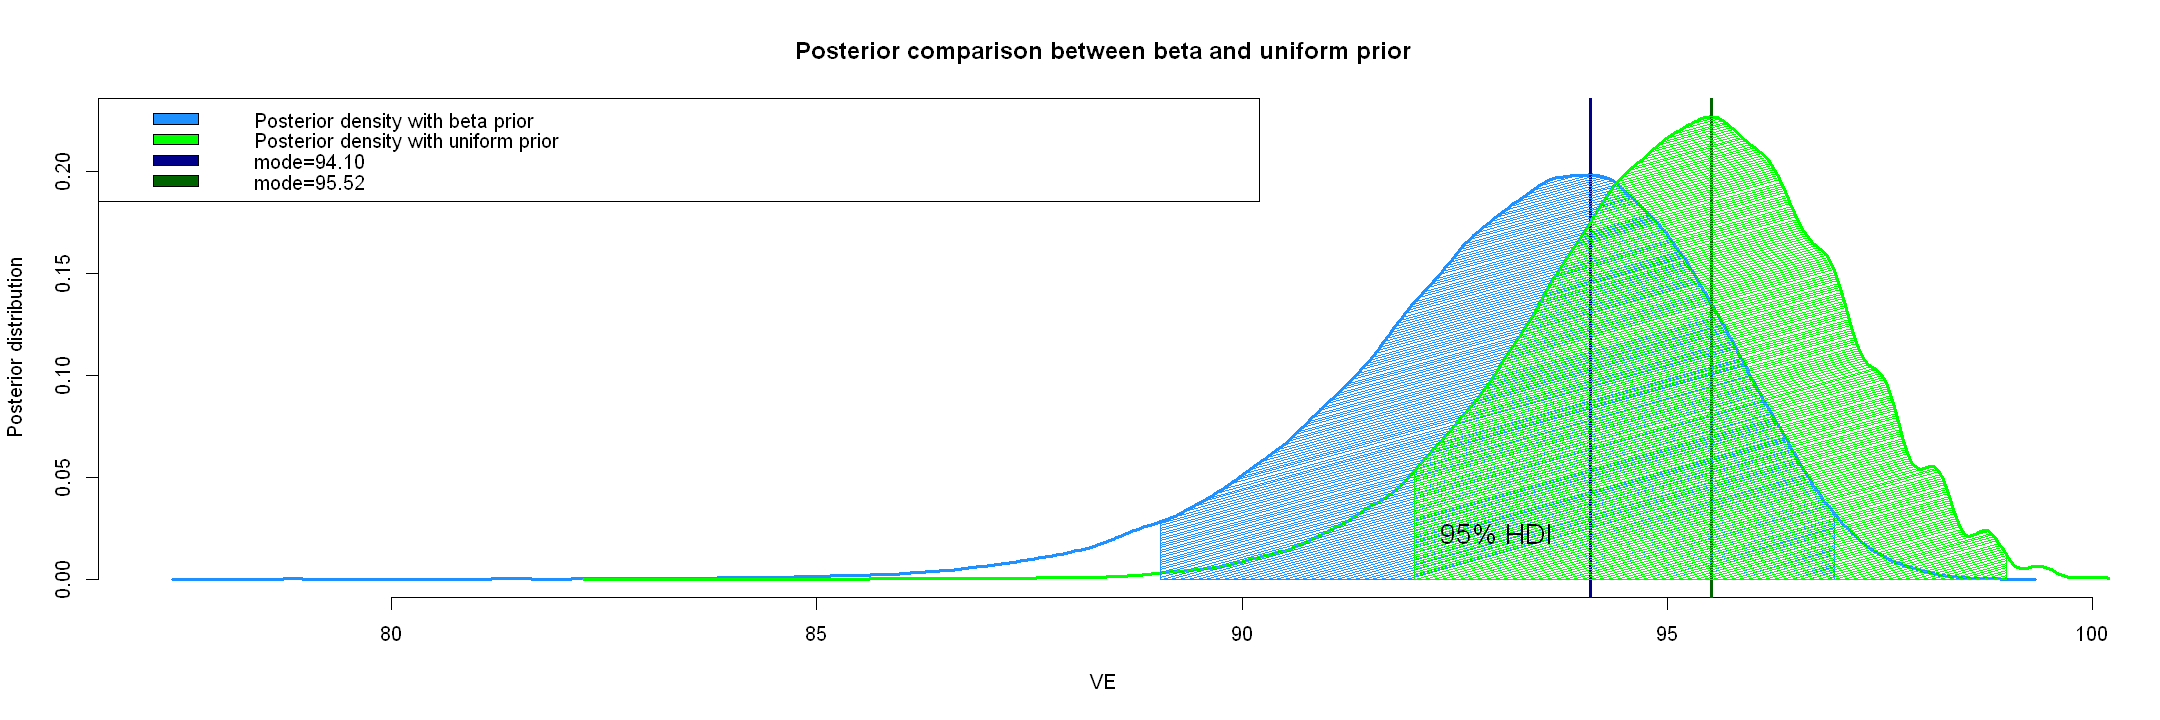

In [20]:
priorcomparison(posterior(), posterior.uniform(), main = "Posterior comparison between beta and uniform prior", xlab = "VE")